In [1]:
# !pip -q install -U timm transformers huggingface_hub pyarrow tqdm

In [2]:
import warnings

warnings.filterwarnings("ignore")

import logging
logging.getLogger("nltk").setLevel(logging.ERROR)
logging.getLogger("bllipparser").setLevel(logging.ERROR)

In [3]:
import os

os.environ['PYTHONWARNINGS'] = 'ignore'

In [4]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

print("Tokenizer parallelism disabled. The warning should be gone now.")

Tokenizer parallelism disabled. The warning should be gone now.


## **PHASE 1**

In [5]:
import os, re, ast, glob, math, json, random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import timm
from torch.utils.data import Dataset, DataLoader

from transformers import BertModel, AutoTokenizer
from huggingface_hub import hf_hub_download

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# -------------------------
# Kaggle dataset paths (edit only if yours differs)
# -------------------------
MIMIC_BASE = "/kaggle/input/mimic-cxr-dataset/official_data_iccv_final"
MIMIC_TRAIN_CSV = "/kaggle/input/mimic-cxr-dataset/mimic_cxr_aug_train.csv"
MIMIC_VAL_CSV   = "/kaggle/input/mimic-cxr-dataset/mimic_cxr_aug_validate.csv"

IU_BASE = "/kaggle/input/chest-xrays-indiana-university"
IU_IMAGES_DIR = None  # auto-detect below
IU_REPORTS_CSV = f"{IU_BASE}/indiana_reports.csv"
IU_PROJ_CSV    = f"{IU_BASE}/indiana_projections.csv"

OUT_DIR = "/kaggle/working/phase1_outputs_v2"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# -------------------------
# Run toggles
# -------------------------
RUN_LABEL_MIMIC = True
RUN_LABEL_IU = True
RUN_SMOKE_TRAIN_IMAGE_CLASSIFIER = True

# Speed toggles (set None to run full)
LIMIT_MIMIC_TRAIN = None   # e.g. 5000 for quick debug, None for full
LIMIT_MIMIC_VAL   = None   # e.g. 200, None for full

# Smoke train config
SMOKE_TRAIN_N = 12000
SMOKE_VAL_N = 500
SMOKE_EPOCHS = 2

print("OUT_DIR:", OUT_DIR)

device: cuda
OUT_DIR: /kaggle/working/phase1_outputs_v2


In [6]:
def parse_list_field(x):
    """Parse stringified python list from CSV. Returns list[str]."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, list):
        return x
    s = str(x).strip()
    if s in ("", "[]", "nan", "None"):
        return []
    try:
        v = ast.literal_eval(s)
        return v if isinstance(v, list) else []
    except Exception:
        return []

def first_existing_path(rel_list, base_dir):
    """Return first existing joined path for rel paths in rel_list, else None."""
    for rel in rel_list:
        if rel is None:
            continue
        rel = str(rel).strip()
        if rel == "":
            continue
        p = os.path.join(base_dir, rel)
        if os.path.exists(p):
            return p
    return None

def build_best_paths_mimic(df, base_dir):
    """
    Builds:
      - best_frontal_path: prefer PA then AP (first existing)
      - best_lateral_path: from Lateral list (first existing)
    """
    best_frontal = []
    best_lat = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="building paths (mimic)"):
        pa_list = parse_list_field(row.get("PA", None))
        ap_list = parse_list_field(row.get("AP", None))
        lat_list = parse_list_field(row.get("Lateral", None))

        p_front = first_existing_path(pa_list, base_dir)
        if p_front is None:
            p_front = first_existing_path(ap_list, base_dir)

        p_lat = first_existing_path(lat_list, base_dir)
        best_frontal.append(p_front)
        best_lat.append(p_lat)

    df = df.copy()
    df["best_frontal_path"] = best_frontal
    df["best_lateral_path"] = best_lat
    return df

def autodetect_iu_images_dir(iu_base):
    # common Kaggle layouts
    candidates = [
        f"{iu_base}/images",
        f"{iu_base}/Images",
        f"{iu_base}/images/images",
        f"{iu_base}/images/images_normalized",
    ]
    for c in candidates:
        if os.path.isdir(c) and len(os.listdir(c)) > 10:
            return c
    # fallback: find a directory that contains many .png
    hits = glob.glob(f"{iu_base}/**/*.png", recursive=True)
    if hits:
        return str(Path(hits[0]).parent)
    return None

In [7]:
print("Loading MIMIC CSVs...")
df_mimic_train = pd.read_csv(MIMIC_TRAIN_CSV)
df_mimic_val   = pd.read_csv(MIMIC_VAL_CSV)

print("MIMIC train rows:", len(df_mimic_train), "val rows:", len(df_mimic_val))

if LIMIT_MIMIC_TRAIN is not None:
    df_mimic_train = df_mimic_train.sample(LIMIT_MIMIC_TRAIN, random_state=SEED).reset_index(drop=True)
if LIMIT_MIMIC_VAL is not None:
    df_mimic_val = df_mimic_val.sample(LIMIT_MIMIC_VAL, random_state=SEED).reset_index(drop=True)

df_mimic_train = build_best_paths_mimic(df_mimic_train, MIMIC_BASE)
df_mimic_val   = build_best_paths_mimic(df_mimic_val, MIMIC_BASE)

print("Train with frontal image:", df_mimic_train["best_frontal_path"].notna().mean())
print("Val with frontal image:", df_mimic_val["best_frontal_path"].notna().mean())

# keep text column name consistent
TEXT_COL = "text" if "text" in df_mimic_train.columns else "text_augment"
print("Using text column:", TEXT_COL)

Loading MIMIC CSVs...
MIMIC train rows: 64586 val rows: 500


building paths (mimic):   0%|          | 0/64586 [00:00<?, ?it/s]

building paths (mimic):   0%|          | 0/500 [00:00<?, ?it/s]

Train with frontal image: 0.6842194902920138
Val with frontal image: 0.66
Using text column: text


In [8]:
CHEX_LABELS = [
    "Enlarged Cardiomediastinum",
    "Cardiomegaly",
    "Lung Opacity",
    "Lung Lesion",
    "Edema",
    "Consolidation",
    "Pneumonia",
    "Atelectasis",
    "Pneumothorax",
    "Pleural Effusion",
    "Pleural Other",
    "Fracture",
    "Support Devices",
    "No Finding",
]

def _extract_state_dict(ckpt_obj):
    if isinstance(ckpt_obj, dict):
        for k in ["state_dict", "model_state_dict", "model_state", "model"]:
            if k in ckpt_obj and isinstance(ckpt_obj[k], dict):
                return ckpt_obj[k]
    return ckpt_obj

def _strip_module_prefix(sd):
    out = {}
    for k, v in sd.items():
        out[k[len("module."):]] = v if k.startswith("module.") else v
    # above line doesn't rewrite keys if no prefix; fix properly:
    out = {}
    for k, v in sd.items():
        if k.startswith("module."):
            out[k[len("module."):]] = v
        else:
            out[k] = v
    return out

def _infer_head_dims(sd, n_heads=14):
    dims = []
    for i in range(n_heads):
        wkey = f"linear_heads.{i}.weight"
        if wkey not in sd:
            raise KeyError(f"Missing {wkey} in checkpoint. Head keys not found.")
        dims.append(sd[wkey].shape[0])
    return dims

class CheXbertFromCheckpoint(nn.Module):
    def __init__(self, head_dims, base_bert="bert-base-uncased"):
        super().__init__()
        self.bert = BertModel.from_pretrained(base_bert)
        hid = self.bert.config.hidden_size
        self.linear_heads = nn.ModuleList([nn.Linear(hid, d) for d in head_dims])

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        cls = out.last_hidden_state[:, 0, :]  # CLS embedding [B,H]
        return [head(cls) for head in self.linear_heads]  # list of [B, d_i]

print("Downloading CheXbert checkpoint (HF cache)... (Kaggle internet ON)")
chexbert_ckpt_path = hf_hub_download(repo_id="StanfordAIMI/RRG_scorers", filename="chexbert.pth")
print("chexbert_ckpt_path:", chexbert_ckpt_path)

ckpt = torch.load(chexbert_ckpt_path, map_location="cpu")
sd = _strip_module_prefix(_extract_state_dict(ckpt))
head_dims = _infer_head_dims(sd, n_heads=14)
print("Inferred head_dims:", head_dims)

chexbert = CheXbertFromCheckpoint(head_dims=head_dims).to(device).eval()

# STRICT load (this must NOT mismatch)
try:
    chexbert.load_state_dict(sd, strict=True)
    print("CheXbert STRICT load OK ✅")
except Exception as e:
    print("CheXbert STRICT load FAILED ❌")
    raise

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

chexbert.pth:   0%|          | 0.00/1.31G [00:00<?, ?B/s]

chexbert_ckpt_path: /root/.cache/huggingface/hub/models--StanfordAIMI--RRG_scorers/snapshots/6646433b3ad83a10f6e141db76d0ece44312b236/chexbert.pth
Inferred head_dims: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2]


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


CheXbert STRICT load OK ✅


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
@torch.no_grad()
def chexbert_predict_classids(texts, max_len=256):
    toks = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    ).to(device)

    logits_list = chexbert(**toks)  # list length 14
    # class id per head
    class_ids = []
    for lg in logits_list:
        class_ids.append(lg.argmax(dim=-1).detach().cpu().numpy())  # [B]
    return np.stack(class_ids, axis=1)  # [B,14]

def classid_to_chex_value(cid):
    # CheXbert convention: 0=blank, 1=positive, 2=negative, 3=uncertain
    if cid == 0:  return np.nan
    if cid == 1:  return 1.0
    if cid == 2:  return 0.0
    if cid == 3:  return -1.0
    return np.nan

def decode_row(vals):
    # vals: [14] of np.nan/1/0/-1
    out = {}
    for i, name in enumerate(CHEX_LABELS):
        out[name] = vals[i]
    return out

tests = [
    "No acute cardiopulmonary abnormality.",
    "There is a large right pneumothorax.",
    "No pneumothorax is seen.",
    "Cannot exclude a small pleural effusion."
]

cids = chexbert_predict_classids(tests)
print("CheXbert class-ids shape:", cids.shape)

vals = np.vectorize(classid_to_chex_value)(cids)
for t, v in zip(tests, vals):
    print("\nTEXT:", t)
    # print a few key labels for sanity
    for k in ["No Finding", "Pneumothorax", "Pleural Effusion", "Consolidation", "Pneumonia"]:
        print(f"  {k:18s} -> {decode_row(v)[k]}")


CheXbert class-ids shape: (4, 14)

TEXT: No acute cardiopulmonary abnormality.
  No Finding         -> 1.0
  Pneumothorax       -> nan
  Pleural Effusion   -> nan
  Consolidation      -> nan
  Pneumonia          -> nan

TEXT: There is a large right pneumothorax.
  No Finding         -> nan
  Pneumothorax       -> 1.0
  Pleural Effusion   -> nan
  Consolidation      -> nan
  Pneumonia          -> nan

TEXT: No pneumothorax is seen.
  No Finding         -> 1.0
  Pneumothorax       -> 0.0
  Pleural Effusion   -> nan
  Consolidation      -> nan
  Pneumonia          -> nan

TEXT: Cannot exclude a small pleural effusion.
  No Finding         -> nan
  Pneumothorax       -> nan
  Pleural Effusion   -> -1.0
  Consolidation      -> nan
  Pneumonia          -> nan


In [10]:
@torch.no_grad()
def label_df_chexbert(df: pd.DataFrame, text_col: str, batch_size=32, max_len=256):
    texts = df[text_col].fillna("").astype(str).tolist()
    all_vals = []

    for i in tqdm(range(0, len(texts), batch_size), desc="CheXbert labeling"):
        chunk = texts[i:i+batch_size]
        cids = chexbert_predict_classids(chunk, max_len=max_len)  # [b,14]
        vals = np.vectorize(classid_to_chex_value)(cids)          # [b,14]
        all_vals.append(vals)

    all_vals = np.concatenate(all_vals, axis=0)  # [N,14]
    out = df.copy()
    for j, name in enumerate(CHEX_LABELS):
        out[name] = all_vals[:, j]
    return out

def prevalence_pos_or_uncertain(df):
    # pos_or_uncertain: count (==1 or ==-1)
    prev = {}
    for name in CHEX_LABELS:
        x = df[name].to_numpy()
        prev[name] = float(np.nanmean((x == 1.0) | (x == -1.0)))
    return prev


In [11]:
# ------------------------
# MIMIC labeling
# ------------------------
if RUN_LABEL_MIMIC:
    df_train_lab = df_mimic_train.copy()
    df_val_lab   = df_mimic_val.copy()

    # label only rows with text (still ok if empty, but keep consistent)
    df_train_lab = label_df_chexbert(df_train_lab, TEXT_COL, batch_size=32, max_len=256)
    df_val_lab   = label_df_chexbert(df_val_lab, TEXT_COL, batch_size=32, max_len=256)

    train_out = f"{OUT_DIR}/mimic_train_chexbert.parquet"
    val_out   = f"{OUT_DIR}/mimic_val_chexbert.parquet"
    df_train_lab.to_parquet(train_out, index=False)
    df_val_lab.to_parquet(val_out, index=False)

    print("Saved:")
    print(" ", train_out)
    print(" ", val_out)

    print("\nLabel prevalence (pos_or_uncertain) on TRAIN:")
    prev = prevalence_pos_or_uncertain(df_train_lab)
    for k, v in prev.items():
        print(f"{k:28s} prevalence={v:.4f}")

# ------------------------
# IU labeling
# ------------------------
if RUN_LABEL_IU:
    IU_IMAGES_DIR = autodetect_iu_images_dir(IU_BASE)
    print("IU_IMAGES_DIR:", IU_IMAGES_DIR)

    df_iu_rep = pd.read_csv(IU_REPORTS_CSV)
    df_iu_proj = pd.read_csv(IU_PROJ_CSV)

    # Build best frontal/lateral per uid using projections
    # projection: "Frontal"/"Lateral"
    front_map = {}
    lat_map = {}
    for uid, g in df_iu_proj.groupby("uid"):
        g = g.copy()
        fr = g[g["projection"].str.lower() == "frontal"]["filename"].tolist()
        la = g[g["projection"].str.lower() == "lateral"]["filename"].tolist()
        front_map[uid] = fr
        lat_map[uid] = la

    best_front = []
    best_lat = []
    for _, row in tqdm(df_iu_rep.iterrows(), total=len(df_iu_rep), desc="building paths (iu)"):
        uid = row["uid"]
        fr_list = front_map.get(uid, [])
        la_list = lat_map.get(uid, [])
        p_front = first_existing_path(fr_list, IU_IMAGES_DIR)
        p_lat   = first_existing_path(la_list, IU_IMAGES_DIR)
        best_front.append(p_front)
        best_lat.append(p_lat)

    df_iu_rep["best_frontal_path"] = best_front
    df_iu_rep["best_lateral_path"] = best_lat

    # Build text: Findings + Impression (and optionally indication)
    def safe_str(x):
        return "" if (x is None or (isinstance(x, float) and np.isnan(x))) else str(x)

    iu_text = []
    for _, r in df_iu_rep.iterrows():
        ind = safe_str(r.get("indication", ""))
        fin = safe_str(r.get("findings", ""))
        imp = safe_str(r.get("impression", ""))
        # keep a stable structure (helps labeler)
        t = f"Indication: {ind}\nFindings: {fin}\nImpression: {imp}"
        iu_text.append(t)
    df_iu_rep["full_text"] = iu_text

    df_iu_lab = label_df_chexbert(df_iu_rep, "full_text", batch_size=64, max_len=256)

    iu_out = f"{OUT_DIR}/iu_chexbert.parquet"
    df_iu_lab.to_parquet(iu_out, index=False)
    print("Saved:", iu_out)

print("\nDONE labeling. Files now in:", OUT_DIR)
print(os.listdir(OUT_DIR))


CheXbert labeling:   0%|          | 0/2019 [00:00<?, ?it/s]

CheXbert labeling:   0%|          | 0/16 [00:00<?, ?it/s]

Saved:
  /kaggle/working/phase1_outputs_v2/mimic_train_chexbert.parquet
  /kaggle/working/phase1_outputs_v2/mimic_val_chexbert.parquet

Label prevalence (pos_or_uncertain) on TRAIN:
Enlarged Cardiomediastinum   prevalence=0.1421
Cardiomegaly                 prevalence=0.2649
Lung Opacity                 prevalence=0.2496
Lung Lesion                  prevalence=0.0536
Edema                        prevalence=0.1352
Consolidation                prevalence=0.0768
Pneumonia                    prevalence=0.1755
Atelectasis                  prevalence=0.3142
Pneumothorax                 prevalence=0.0226
Pleural Effusion             prevalence=0.2021
Pleural Other                prevalence=0.0362
Fracture                     prevalence=0.0512
Support Devices              prevalence=0.2407
No Finding                   prevalence=0.2779
IU_IMAGES_DIR: /kaggle/input/chest-xrays-indiana-university/images/images_normalized


building paths (iu):   0%|          | 0/3851 [00:00<?, ?it/s]

CheXbert labeling:   0%|          | 0/61 [00:00<?, ?it/s]

Saved: /kaggle/working/phase1_outputs_v2/iu_chexbert.parquet

DONE labeling. Files now in: /kaggle/working/phase1_outputs_v2
['mimic_val_chexbert.parquet', 'iu_chexbert.parquet', 'mimic_train_chexbert.parquet']


In [12]:
def make_binary_targets(df: pd.DataFrame, policy="pos_or_uncertain"):
    # returns y (N,14) in {0,1}
    arr = df[CHEX_LABELS].to_numpy()
    if policy == "pos_or_uncertain":
        y = ((arr == 1.0) | (arr == -1.0)).astype(np.float32)
    elif policy == "pos_only":
        y = (arr == 1.0).astype(np.float32)
    else:
        raise ValueError("policy must be pos_or_uncertain or pos_only")
    # NaNs produce False in comparisons; fine.
    return y

def build_transforms(img_size=224):
    import torchvision.transforms as T
    return T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
    ])

class MIMICCheXDataset(Dataset):
    def __init__(self, df: pd.DataFrame, y: np.ndarray, transform):
        self.df = df.reset_index(drop=True)
        self.y = torch.from_numpy(y).float()
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        p = self.df.loc[idx, "best_frontal_path"]
        img = Image.open(p).convert("RGB")
        img = self.transform(img)
        return img, self.y[idx]

class MixMLPHead(nn.Module):
    def __init__(self, d_in: int, d_hidden: int = 1024, n_labels: int = 14, drop: float = 0.1):
        super().__init__()
        self.res = nn.Sequential(
            nn.LayerNorm(d_in),
            nn.Linear(d_in, d_in),
            nn.GELU(),
            nn.Dropout(drop),
        )
        self.exp = nn.Sequential(
            nn.LayerNorm(d_in),
            nn.Linear(d_in, d_hidden),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(d_hidden, d_in),
            nn.GELU(),
            nn.Dropout(drop),
        )
        self.fuse = nn.Sequential(
            nn.LayerNorm(d_in),
            nn.Linear(d_in, d_in),
            nn.GELU(),
            nn.Dropout(drop),
        )
        self.out = nn.Linear(d_in, n_labels)

    def forward(self, x):
        x2 = x + self.res(x) + self.exp(x)
        x2 = self.fuse(x2)
        return self.out(x2)

class FrozenBackboneClassifier(nn.Module):
    def __init__(self, backbone_name="resnet50", n_labels=14):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool="avg")
        d = self.backbone.num_features
        for p in self.backbone.parameters():
            p.requires_grad = False
        self.head = MixMLPHead(d_in=d, d_hidden=1024, n_labels=n_labels)

    def forward(self, x):
        feat = self.backbone(x)
        return self.head(feat)

def multilabel_f1(y_true: np.ndarray, y_prob: np.ndarray, thr=0.5):
    y_pred = (y_prob >= thr).astype(np.int32)
    eps = 1e-9

    tp = (y_true * y_pred).sum()
    fp = ((1 - y_true) * y_pred).sum()
    fn = (y_true * (1 - y_pred)).sum()
    p = tp / (tp + fp + eps)
    r = tp / (tp + fn + eps)
    f1_micro = 2 * p * r / (p + r + eps)

    f1s = []
    for k in range(y_true.shape[1]):
        yt = y_true[:, k]
        yp = y_pred[:, k]
        tp = (yt * yp).sum()
        fp = ((1 - yt) * yp).sum()
        fn = (yt * (1 - yp)).sum()
        p = tp / (tp + fp + eps)
        r = tp / (tp + fn + eps)
        f1s.append(2 * p * r / (p + r + eps))
    f1_macro = float(np.mean(f1s))
    return {"f1_micro": float(f1_micro), "f1_macro": float(f1_macro)}

def run_smoke_train(df_train_lab: pd.DataFrame, df_val_lab: pd.DataFrame):
    # Filter must-have image path
    df_train_lab = df_train_lab[df_train_lab["best_frontal_path"].notna()].reset_index(drop=True)
    df_val_lab   = df_val_lab[df_val_lab["best_frontal_path"].notna()].reset_index(drop=True)

    df_tr = df_train_lab.sample(min(SMOKE_TRAIN_N, len(df_train_lab)), random_state=SEED).reset_index(drop=True)
    df_va = df_val_lab.sample(min(SMOKE_VAL_N, len(df_val_lab)), random_state=SEED).reset_index(drop=True)

    y_tr = make_binary_targets(df_tr, policy="pos_or_uncertain")
    y_va = make_binary_targets(df_va, policy="pos_or_uncertain")

    tfm = build_transforms(224)
    ds_tr = MIMICCheXDataset(df_tr, y_tr, tfm)
    ds_va = MIMICCheXDataset(df_va, y_va, tfm)

    dl_tr = DataLoader(ds_tr, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
    dl_va = DataLoader(ds_va, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

    model = FrozenBackboneClassifier("resnet50", n_labels=14).to(device)
    opt = torch.optim.AdamW(model.head.parameters(), lr=2e-3, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
    loss_fn = nn.BCEWithLogitsLoss()

    best_macro = -1.0
    best_path = f"{OUT_DIR}/smoke_classifier_best.pt"

    for epoch in range(1, SMOKE_EPOCHS + 1):
        model.train()
        tr_losses = []
        for x, y in tqdm(dl_tr, desc=f"train epoch {epoch}"):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(x)
                loss = loss_fn(logits, y)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            tr_losses.append(loss.item())

        model.eval()
        probs = []
        ys = []
        with torch.no_grad():
            for x, y in tqdm(dl_va, desc=f"eval epoch {epoch}"):
                x = x.to(device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                    logits = model(x)
                    p = torch.sigmoid(logits).float().cpu().numpy()
                probs.append(p)
                ys.append(y.numpy())

        probs = np.concatenate(probs, axis=0)
        ys = np.concatenate(ys, axis=0)
        m = multilabel_f1(ys, probs, thr=0.5)

        print(f"\nEpoch {epoch}: train_loss={np.mean(tr_losses):.4f}  val_f1_micro={m['f1_micro']:.4f}  val_f1_macro={m['f1_macro']:.4f}")

        if m["f1_macro"] > best_macro:
            best_macro = m["f1_macro"]
            torch.save({"model": model.state_dict(), "epoch": epoch, "metrics": m}, best_path)

    print("\nSaved best smoke classifier:", best_path)
    ck = torch.load(best_path, map_location="cpu")
    print("Best epoch:", ck["epoch"], "metrics:", ck["metrics"])

# Load labeled data from disk (ensures we're using the new v2 labels)
df_train_lab = pd.read_parquet(f"{OUT_DIR}/mimic_train_chexbert.parquet")
df_val_lab   = pd.read_parquet(f"{OUT_DIR}/mimic_val_chexbert.parquet")

if RUN_SMOKE_TRAIN_IMAGE_CLASSIFIER and RUN_LABEL_MIMIC:
    run_smoke_train(df_train_lab, df_val_lab)

print("\nDONE. Phase-1 artifacts in:", OUT_DIR)
print("Files:", os.listdir(OUT_DIR))


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

train epoch 1:   0%|          | 0/375 [00:00<?, ?it/s]

eval epoch 1:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1: train_loss=0.3939  val_f1_micro=0.3494  val_f1_macro=0.1977


train epoch 2:   0%|          | 0/375 [00:00<?, ?it/s]

eval epoch 2:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 2: train_loss=0.3651  val_f1_micro=0.3646  val_f1_macro=0.1852

Saved best smoke classifier: /kaggle/working/phase1_outputs_v2/smoke_classifier_best.pt
Best epoch: 1 metrics: {'f1_micro': 0.349429323516351, 'f1_macro': 0.1977358077380726}

DONE. Phase-1 artifacts in: /kaggle/working/phase1_outputs_v2
Files: ['smoke_classifier_best.pt', 'mimic_val_chexbert.parquet', 'iu_chexbert.parquet', 'mimic_train_chexbert.parquet']


----------------------------------------------------------

## **PHASE 2**

In [13]:
import os, math, json, random
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Tuple, Optional, List

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import timm
from timm.data import resolve_data_config, create_transform
from sklearn.metrics import roc_auc_score, average_precision_score

In [14]:
# -----------------------
# Config
# -----------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

PHASE1_DIR = "/kaggle/working/phase1_outputs_v2"   # <- change if your Phase-1 OUT_DIR differs
PHASE2_DIR = "/kaggle/working/phase2_outputs_v1"
Path(PHASE2_DIR).mkdir(parents=True, exist_ok=True)
print("PHASE1_DIR:", PHASE1_DIR)
print("PHASE2_DIR:", PHASE2_DIR)

# Labels (CheXpert 14) - keep this order consistent everywhere
CHEX_LABELS = [
    "Enlarged Cardiomediastinum",
    "Cardiomegaly",
    "Lung Opacity",
    "Lung Lesion",
    "Edema",
    "Consolidation",
    "Pneumonia",
    "Atelectasis",
    "Pneumothorax",
    "Pleural Effusion",
    "Pleural Other",
    "Fracture",
    "Support Devices",
    "No Finding",
]
N_LABELS = len(CHEX_LABELS)

# Training knobs (T4-friendly)
BACKBONE_NAME = "convnext_tiny"   # good default
IMG_SIZE = 224

BATCH_SIZE = 32
NUM_WORKERS = 2

EPOCHS = 6
WARMUP_EPOCHS = 1  # head-only
LR_HEAD = 2e-3
LR_BACKBONE = 2e-5
WEIGHT_DECAY = 1e-4

# for speed / debugging
TRAIN_FRAC = 1.0      # set 0.3 if you want quick test
VAL_FRAC = 0.08       # subject-wise val split fraction from train parquet

AMP = True


device: cuda
PHASE1_DIR: /kaggle/working/phase1_outputs_v2
PHASE2_DIR: /kaggle/working/phase2_outputs_v1


In [15]:
train_pq = os.path.join(PHASE1_DIR, "mimic_train_chexbert.parquet")
holdout_pq = os.path.join(PHASE1_DIR, "mimic_val_chexbert.parquet")  # Kaggle validate.csv labeling output

assert os.path.exists(train_pq), f"Missing: {train_pq}"
assert os.path.exists(holdout_pq), f"Missing: {holdout_pq}"

df_all = pd.read_parquet(train_pq)
df_holdout = pd.read_parquet(holdout_pq)

print("Loaded df_all:", df_all.shape, "df_holdout:", df_holdout.shape)

# Ensure required columns exist
need_cols = ["subject_id", "best_frontal_path"] + CHEX_LABELS
for c in need_cols:
    assert c in df_all.columns, f"Missing column in df_all: {c}"
for c in ["best_frontal_path"] + CHEX_LABELS:
    assert c in df_holdout.columns, f"Missing column in df_holdout: {c}"

# optional lateral
if "best_lateral_path" not in df_all.columns:
    df_all["best_lateral_path"] = None
if "best_lateral_path" not in df_holdout.columns:
    df_holdout["best_lateral_path"] = None

# Filter rows with existing frontal files
def file_exists(p):
    return isinstance(p, str) and len(p) > 0 and os.path.exists(p)

df_all = df_all[df_all["best_frontal_path"].apply(file_exists)].reset_index(drop=True)
df_holdout = df_holdout[df_holdout["best_frontal_path"].apply(file_exists)].reset_index(drop=True)

print("After frontal-exists filter:")
print(" df_all:", df_all.shape, " df_holdout:", df_holdout.shape)

# Optional speed subsample (subject-safe later)
if TRAIN_FRAC < 1.0:
    # sample subjects not rows (better)
    subs = df_all[["subject_id"]].drop_duplicates()
    subs = subs.sample(frac=TRAIN_FRAC, random_state=SEED)
    df_all = df_all[df_all["subject_id"].isin(set(subs["subject_id"]))].reset_index(drop=True)
    print("After TRAIN_FRAC subject subsample:", df_all.shape)


Loaded df_all: (64586, 26) df_holdout: (500, 26)
After frontal-exists filter:
 df_all: (44191, 26)  df_holdout: (330, 26)


In [16]:
# -----------------------
# Subject-wise split to avoid leakage
# -----------------------
subj = df_all[["subject_id"]].drop_duplicates().reset_index(drop=True)
subj = subj.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

n_val_subj = int(len(subj) * VAL_FRAC)
val_subj = set(subj.iloc[:n_val_subj]["subject_id"])
tr_subj = set(subj.iloc[n_val_subj:]["subject_id"])

df_tr = df_all[df_all["subject_id"].isin(tr_subj)].reset_index(drop=True)
df_va = df_all[df_all["subject_id"].isin(val_subj)].reset_index(drop=True)

print("Split:")
print(" df_tr:", df_tr.shape, " df_va:", df_va.shape)

# -----------------------
# Build y + mask
# policy: pos_or_uncertain => 1 if value in {1, -1}, 0 if 0, ignore if NaN
# -----------------------
def make_targets_and_mask(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    y = np.zeros((len(df), N_LABELS), dtype=np.float32)
    m = np.zeros((len(df), N_LABELS), dtype=np.float32)
    for j, lab in enumerate(CHEX_LABELS):
        v = df[lab].values
        is_valid = ~pd.isna(v)
        m[:, j] = is_valid.astype(np.float32)
        # positive if 1 or -1
        y[:, j] = ((v == 1) | (v == -1)).astype(np.float32)
    return y, m

y_tr, m_tr = make_targets_and_mask(df_tr)
y_va, m_va = make_targets_and_mask(df_va)
y_ho, m_ho = make_targets_and_mask(df_holdout)

# pos_weight per label: neg/pos computed only on valid entries
eps = 1e-6
pos = (y_tr * m_tr).sum(axis=0)
neg = ((1.0 - y_tr) * m_tr).sum(axis=0)
pos_weight = neg / (pos + eps)
pos_weight_t = torch.tensor(pos_weight, dtype=torch.float32, device=device)

print("pos_weight (first 5):", pos_weight[:5])
print("Valid counts per label (train):", m_tr.sum(axis=0).astype(int))


Split:
 df_tr: (40656, 26)  df_va: (3535, 26)
pos_weight (first 5): [3.9891994  1.5872655  0.11517708 0.2825112  2.2543435 ]
Valid counts per label (train): [29102 28403 11367  2860 18169 20484 15411 13089 32674 35872  1509  4157
 10061 11059]


In [17]:
class MIMICMultiViewDataset(Dataset):
    """
    Returns:
      x_views: [V=2, C, H, W]
      view_mask: [V] (1 if view exists else 0)
      y: [14]
      y_mask: [14] (valid label or not)
    """
    def __init__(self, df: pd.DataFrame, y: np.ndarray, y_mask: np.ndarray, tfm):
        self.df = df.reset_index(drop=True)
        self.y = torch.from_numpy(y).float()
        self.y_mask = torch.from_numpy(y_mask).float()
        self.tfm = tfm

    def __len__(self):
        return len(self.df)

    def _load_img(self, path: Optional[str]) -> Optional[torch.Tensor]:
        if not (isinstance(path, str) and len(path) > 0 and os.path.exists(path)):
            return None
        img = Image.open(path).convert("RGB")
        return self.tfm(img)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        p_fr = row["best_frontal_path"]
        p_la = row.get("best_lateral_path", None)

        x_fr = self._load_img(p_fr)
        x_la = self._load_img(p_la)

        views = []
        mask = []

        # Frontal always present (we filtered), but keep robust
        if x_fr is None:
            x_fr = torch.zeros(3, IMG_SIZE, IMG_SIZE)
            mask.append(0.0)
        else:
            mask.append(1.0)
        views.append(x_fr)

        if x_la is None:
            x_la = torch.zeros(3, IMG_SIZE, IMG_SIZE)
            mask.append(0.0)
        else:
            mask.append(1.0)
        views.append(x_la)

        x_views = torch.stack(views, dim=0)      # [2, C, H, W]
        view_mask = torch.tensor(mask).float()   # [2]

        return x_views, view_mask, self.y[idx], self.y_mask[idx]


# timm transforms (proper normalize for chosen backbone)
tmp_model = timm.create_model(BACKBONE_NAME, pretrained=True)
data_cfg = resolve_data_config({}, model=tmp_model)
data_cfg["input_size"] = (3, IMG_SIZE, IMG_SIZE)
tfm_train = create_transform(**data_cfg, is_training=True)
tfm_eval  = create_transform(**data_cfg, is_training=False)
del tmp_model

ds_tr = MIMICMultiViewDataset(df_tr, y_tr, m_tr, tfm_train)
ds_va = MIMICMultiViewDataset(df_va, y_va, m_va, tfm_eval)
ds_ho = MIMICMultiViewDataset(df_holdout, y_ho, m_ho, tfm_eval)

dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
dl_ho = DataLoader(ds_ho, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Dataloaders ready:", len(ds_tr), len(ds_va), len(ds_ho))


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Dataloaders ready: 40656 3535 330


In [18]:
class MixMLPHead(nn.Module):
    """
    MIX-MLP spirit: residual path + expansion path + fusion.
    """
    def __init__(self, d_in: int, d_hidden: int = 1024, n_labels: int = 14, drop: float = 0.1):
        super().__init__()
        self.res = nn.Sequential(
            nn.LayerNorm(d_in),
            nn.Linear(d_in, d_in),
            nn.GELU(),
            nn.Dropout(drop),
        )
        self.exp = nn.Sequential(
            nn.LayerNorm(d_in),
            nn.Linear(d_in, d_hidden),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(d_hidden, d_in),
            nn.GELU(),
            nn.Dropout(drop),
        )
        self.fuse = nn.Sequential(
            nn.LayerNorm(d_in),
            nn.Linear(d_in, d_in),
            nn.GELU(),
            nn.Dropout(drop),
        )
        self.out = nn.Linear(d_in, n_labels)

    def forward(self, x):
        x2 = x + self.res(x) + self.exp(x)
        x2 = self.fuse(x2)
        return self.out(x2)


class MultiViewClassifier(nn.Module):
    """
    x_views: [B, V=2, C, H, W]
    view_mask: [B, V] where 1 means view exists else 0
    """
    def __init__(self, backbone_name: str, n_labels: int = 14):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool="avg")
        d = self.backbone.num_features

        # View attention (learn weights across views)
        self.view_score = nn.Sequential(
            nn.LayerNorm(d),
            nn.Linear(d, 1)
        )

        self.head = MixMLPHead(d_in=d, d_hidden=1024, n_labels=n_labels, drop=0.1)

    def forward(self, x_views, view_mask):
        B, V, C, H, W = x_views.shape
        x = x_views.view(B * V, C, H, W)
        feat = self.backbone(x)             # [B*V, D]
        D = feat.shape[-1]
        feat = feat.view(B, V, D)           # [B, V, D]

        scores = self.view_score(feat).squeeze(-1)  # [B, V]
        # mask missing views => -inf
        scores = scores.masked_fill(view_mask <= 0, float("-inf"))

        attn = torch.softmax(scores, dim=1)         # [B, V]
        attn = torch.nan_to_num(attn, nan=0.0)      # if all -inf, softmax -> nan
        fused = (attn.unsqueeze(-1) * feat).sum(dim=1)  # [B, D]

        logits = self.head(fused)                   # [B, 14]
        return logits


model = MultiViewClassifier(BACKBONE_NAME, n_labels=N_LABELS).to(device)
print("Model ready. Backbone:", BACKBONE_NAME, "feat_dim:", model.backbone.num_features)

Model ready. Backbone: convnext_tiny feat_dim: 768


In [19]:
def freeze_backbone(m: MultiViewClassifier):
    for p in m.backbone.parameters():
        p.requires_grad = False

def unfreeze_convnext_last_stage(m: MultiViewClassifier):
    """
    For convnext_* in timm: backbone has stages[0..3].
    Unfreeze stages[3] + final norm/head-like parts if present.
    """
    b = m.backbone
    # freeze everything first (safe)
    for p in b.parameters():
        p.requires_grad = False

    # Unfreeze last stage if present
    if hasattr(b, "stages") and len(b.stages) >= 4:
        for p in b.stages[3].parameters():
            p.requires_grad = True

    # Unfreeze final norm if present
    if hasattr(b, "norm"):
        for p in b.norm.parameters():
            p.requires_grad = True


def masked_bce_with_logits(logits, y, y_mask, pos_weight_vec):
    """
    logits,y,y_mask: [B,14]
    y_mask=1 where label exists else 0
    pos_weight_vec: [14]
    """
    loss = F.binary_cross_entropy_with_logits(
        logits, y, reduction="none", pos_weight=pos_weight_vec
    )  # [B,14]
    loss = loss * y_mask
    denom = y_mask.sum().clamp_min(1.0)
    return loss.sum() / denom

In [20]:
@torch.no_grad()
def predict_probs(model, dl):
    model.eval()
    all_p, all_y, all_m = [], [], []
    for x_views, view_mask, y, y_mask in tqdm(dl, desc="predict", leave=False):
        x_views = x_views.to(device, non_blocking=True)
        view_mask = view_mask.to(device, non_blocking=True)
        y = y.numpy()
        y_mask = y_mask.numpy()
        with torch.cuda.amp.autocast(enabled=AMP and device.type == "cuda"):
            logits = model(x_views, view_mask)
            p = torch.sigmoid(logits).float().cpu().numpy()
        all_p.append(p)
        all_y.append(y)
        all_m.append(y_mask)
    return np.concatenate(all_p, 0), np.concatenate(all_y, 0), np.concatenate(all_m, 0)


def f1_micro_macro(y_true, y_prob, y_mask, thr_vec):
    """
    y_true,y_prob,y_mask: [N,14]
    thr_vec: [14]
    """
    y_pred = (y_prob >= thr_vec.reshape(1, -1)).astype(np.int32)

    # ignore invalid labels using mask by zeroing them out in counts
    eps = 1e-9
    yt = y_true * y_mask
    yp = y_pred * y_mask

    # micro
    tp = (yt * yp).sum()
    fp = ((1 - yt) * yp).sum()
    fn = (yt * (1 - yp)).sum()
    p = tp / (tp + fp + eps)
    r = tp / (tp + fn + eps)
    f1_micro = 2 * p * r / (p + r + eps)

    # macro
    f1s = []
    for k in range(yt.shape[1]):
        valid = y_mask[:, k] > 0
        if valid.sum() == 0:
            f1s.append(0.0); continue
        yt_k = y_true[valid, k]
        yp_k = y_pred[valid, k]
        tp = (yt_k * yp_k).sum()
        fp = ((1 - yt_k) * yp_k).sum()
        fn = (yt_k * (1 - yp_k)).sum()
        p = tp / (tp + fp + eps)
        r = tp / (tp + fn + eps)
        f1s.append(float(2 * p * r / (p + r + eps)))
    return float(f1_micro), float(np.mean(f1s))


def auc_ap_per_label(y_true, y_prob, y_mask):
    aucs, aps = [], []
    for k in range(y_true.shape[1]):
        valid = y_mask[:, k] > 0
        if valid.sum() < 10:
            aucs.append(np.nan); aps.append(np.nan); continue
        yt = y_true[valid, k]
        yp = y_prob[valid, k]
        # If only one class present, AUROC undefined
        if len(np.unique(yt)) < 2:
            aucs.append(np.nan)
        else:
            aucs.append(roc_auc_score(yt, yp))
        aps.append(average_precision_score(yt, yp))
    return np.array(aucs), np.array(aps)


def tune_thresholds(y_true, y_prob, y_mask, grid=None):
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)  # 0.05 steps
    thr = np.zeros((y_true.shape[1],), dtype=np.float32)
    for k in range(y_true.shape[1]):
        valid = y_mask[:, k] > 0
        if valid.sum() < 10:
            thr[k] = 0.5
            continue
        yt = y_true[valid, k]
        yp = y_prob[valid, k]
        if len(np.unique(yt)) < 2:
            thr[k] = 0.5
            continue
        best_f1 = -1.0
        best_t = 0.5
        for t in grid:
            ypred = (yp >= t).astype(np.int32)
            tp = (yt * ypred).sum()
            fp = ((1 - yt) * ypred).sum()
            fn = (yt * (1 - ypred)).sum()
            f1 = (2 * tp) / (2 * tp + fp + fn + 1e-9)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        thr[k] = best_t
    return thr

In [21]:
def make_optimizer(model: MultiViewClassifier, lr_head, lr_backbone):
    head_params = list(model.head.parameters()) + list(model.view_score.parameters())
    backbone_params = [p for p in model.backbone.parameters() if p.requires_grad]

    params = [
        {"params": head_params, "lr": lr_head},
    ]
    if len(backbone_params) > 0:
        params.append({"params": backbone_params, "lr": lr_backbone})

    opt = torch.optim.AdamW(params, weight_decay=WEIGHT_DECAY)
    return opt


best_path = os.path.join(PHASE2_DIR, "best_multiview_classifier.pt")
best_score = -1.0

scaler = torch.cuda.amp.GradScaler(enabled=(AMP and device.type == "cuda"))

# ---- Stage 1: warmup (head-only)
freeze_backbone(model)
for p in model.head.parameters(): p.requires_grad = True
for p in model.view_score.parameters(): p.requires_grad = True

opt = make_optimizer(model, lr_head=LR_HEAD, lr_backbone=LR_BACKBONE)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1, EPOCHS))

for epoch in range(1, EPOCHS + 1):
    # switch unfreezing at epoch = WARMUP_EPOCHS+1
    if epoch == WARMUP_EPOCHS + 1:
        if BACKBONE_NAME.startswith("convnext"):
            unfreeze_convnext_last_stage(model)
        else:
            # fallback: unfreeze everything (you can specialize later)
            for p in model.backbone.parameters():
                p.requires_grad = True
        opt = make_optimizer(model, lr_head=LR_HEAD * 0.5, lr_backbone=LR_BACKBONE)
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1, EPOCHS - epoch + 1))
        print(f"\n[Epoch {epoch}] Unfroze backbone last stage (or full backbone fallback)")

    model.train()
    losses = []

    for x_views, view_mask, y, y_mask in tqdm(dl_tr, desc=f"train epoch {epoch}"):
        x_views = x_views.to(device, non_blocking=True)
        view_mask = view_mask.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        y_mask = y_mask.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=AMP and device.type == "cuda"):
            logits = model(x_views, view_mask)
            loss = masked_bce_with_logits(logits, y, y_mask, pos_weight_t)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        losses.append(loss.item())

    sched.step()

    # ---- Eval on val split
    p_va, yt_va, m_va2 = predict_probs(model, dl_va)

    # fixed threshold baseline
    thr_05 = np.full((N_LABELS,), 0.5, dtype=np.float32)
    f1mi_05, f1ma_05 = f1_micro_macro(yt_va, p_va, m_va2, thr_05)

    # tune thresholds
    thr_tuned = tune_thresholds(yt_va, p_va, m_va2)
    f1mi_t, f1ma_t = f1_micro_macro(yt_va, p_va, m_va2, thr_tuned)

    aucs, aps = auc_ap_per_label(yt_va, p_va, m_va2)
    mean_ap = np.nanmean(aps)

    print(f"\nEpoch {epoch} | train_loss={np.mean(losses):.4f}")
    print(f"  Val F1 @0.5    : micro={f1mi_05:.4f} macro={f1ma_05:.4f}")
    print(f"  Val F1 tuned   : micro={f1mi_t:.4f} macro={f1ma_t:.4f}")
    print(f"  Val mean AP    : {mean_ap:.4f}")

    # Choose a checkpoint criterion
    score = f1ma_t  # macro tuned is a good "balanced" selector
    if score > best_score:
        best_score = score
        torch.save({
            "model": model.state_dict(),
            "epoch": epoch,
            "best_score": best_score,
            "thr_tuned": thr_tuned,
            "backbone": BACKBONE_NAME,
            "img_size": IMG_SIZE,
            "metrics_val": {
                "f1_micro_05": f1mi_05,
                "f1_macro_05": f1ma_05,
                "f1_micro_tuned": f1mi_t,
                "f1_macro_tuned": f1ma_t,
                "mean_ap": float(mean_ap),
            }
        }, best_path)
        print("  ✅ Saved best checkpoint:", best_path)

print("\nTraining done. Best score:", best_score)

train epoch 1:   0%|          | 0/1270 [00:00<?, ?it/s]

predict:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 1 | train_loss=0.7396
  Val F1 @0.5    : micro=0.5938 macro=0.5190
  Val F1 tuned   : micro=0.7770 macro=0.7245
  Val mean AP    : 0.7119
  ✅ Saved best checkpoint: /kaggle/working/phase2_outputs_v1/best_multiview_classifier.pt

[Epoch 2] Unfroze backbone last stage (or full backbone fallback)


train epoch 2:   0%|          | 0/1270 [00:00<?, ?it/s]

predict:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 2 | train_loss=0.7050
  Val F1 @0.5    : micro=0.5790 macro=0.5706
  Val F1 tuned   : micro=0.7776 macro=0.7300
  Val mean AP    : 0.7349
  ✅ Saved best checkpoint: /kaggle/working/phase2_outputs_v1/best_multiview_classifier.pt


train epoch 3:   0%|          | 0/1270 [00:00<?, ?it/s]

predict:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 3 | train_loss=0.6744
  Val F1 @0.5    : micro=0.6124 macro=0.5779
  Val F1 tuned   : micro=0.7292 macro=0.6796
  Val mean AP    : 0.7415


train epoch 4:   0%|          | 0/1270 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e964cb57060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e964cb57060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

predict:   0%|          | 0/56 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e964cb57060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7e964cb57060>
 
  Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^^
^^ ^  ^ ^^  
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^  ^ ^^ ^^^ ^ ^
    File "/usr/li


Epoch 4 | train_loss=0.6566
  Val F1 @0.5    : micro=0.5484 macro=0.5337
  Val F1 tuned   : micro=0.7364 macro=0.6842
  Val mean AP    : 0.7484


train epoch 5:   0%|          | 0/1270 [00:00<?, ?it/s]

predict:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 5 | train_loss=0.6352
  Val F1 @0.5    : micro=0.6443 macro=0.6215
  Val F1 tuned   : micro=0.7453 macro=0.6955
  Val mean AP    : 0.7575


train epoch 6:   0%|          | 0/1270 [00:00<?, ?it/s]

predict:   0%|          | 0/56 [00:00<?, ?it/s]


Epoch 6 | train_loss=0.6256
  Val F1 @0.5    : micro=0.6365 macro=0.6152
  Val F1 tuned   : micro=0.7470 macro=0.6958
  Val mean AP    : 0.7600

Training done. Best score: 0.7299943853284339


In [22]:
import numpy as np
import json, os
import torch

if torch.cuda.is_available():
    torch.cuda.empty_cache()

best_path = os.path.join(PHASE2_DIR, "best_multiview_classifier.pt")
assert os.path.exists(best_path), f"Missing checkpoint: {best_path}"
print("Loading:", best_path)

ck = torch.load(best_path, map_location="cpu", weights_only=False)

# Rebuild model exactly (in case you restarted kernel)
model = MultiViewClassifier(BACKBONE_NAME, n_labels=N_LABELS).to(device)
model.load_state_dict(ck["model"])

thr = np.array(ck["thr_tuned"], dtype=np.float32)  # ensure numpy
print("Loaded best epoch:", ck["epoch"], "best_score:", ck["best_score"])
print("Threshold sample:", thr[:5])

# Evaluate on internal VAL
p_va, yt_va, m_va2 = predict_probs(model, dl_va)
f1mi_v, f1ma_v = f1_micro_macro(yt_va, p_va, m_va2, thr)
aucs_v, aps_v = auc_ap_per_label(yt_va, p_va, m_va2)
mean_ap_v = float(np.nanmean(aps_v))

print("\n=== Internal VAL (subject split) ===")
print("F1 tuned:", {"micro": f1mi_v, "macro": f1ma_v, "meanAP": mean_ap_v})

# Evaluate on HOLDOUT (Phase-1 mimic_val parquet)
p_ho, yt_ho2, m_ho2 = predict_probs(model, dl_ho)
f1mi_h, f1ma_h = f1_micro_macro(yt_ho2, p_ho, m_ho2, thr)
aucs_h, aps_h = auc_ap_per_label(yt_ho2, p_ho, m_ho2)
mean_ap_h = float(np.nanmean(aps_h))

print("\n=== HOLDOUT (Phase-1 mimic_val parquet) ===")
print("F1 tuned:", {"micro": f1mi_h, "macro": f1ma_h, "meanAP": mean_ap_h})

# Save JSON (portable, no pickle)
out_json = os.path.join(PHASE2_DIR, "phase2_metrics_and_thresholds.json")
payload = {
    "best_epoch": int(ck["epoch"]),
    "best_score": float(ck["best_score"]),
    "backbone": ck.get("backbone", BACKBONE_NAME),
    "img_size": int(ck.get("img_size", IMG_SIZE)),
    "thr_tuned": {CHEX_LABELS[i]: float(thr[i]) for i in range(N_LABELS)},
    "val_metrics_recomputed": {
        "f1_micro_tuned": float(f1mi_v),
        "f1_macro_tuned": float(f1ma_v),
        "mean_ap": float(mean_ap_v),
    },
    "holdout_metrics": {
        "f1_micro_tuned": float(f1mi_h),
        "f1_macro_tuned": float(f1ma_h),
        "mean_ap": float(mean_ap_h),
    },
}
with open(out_json, "w") as f:
    json.dump(payload, f, indent=2)
print("\nSaved:", out_json)


# state_dict only + thresholds as plain list
clean_ckpt = os.path.join(PHASE2_DIR, "best_multiview_classifier_clean.pt")
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "epoch": int(ck["epoch"]),
        "best_score": float(ck["best_score"]),
        "thr_tuned_list": [float(x) for x in thr.tolist()],  # plain python
        "backbone": ck.get("backbone", BACKBONE_NAME),
        "img_size": int(ck.get("img_size", IMG_SIZE)),
    },
    clean_ckpt
)
print("Saved clean checkpoint:", clean_ckpt)
print("Artifacts:", os.listdir(PHASE2_DIR))

Loading: /kaggle/working/phase2_outputs_v1/best_multiview_classifier.pt
Loaded best epoch: 2 best_score: 0.7299943853284339
Threshold sample: [0.5  0.35 0.05 0.05 0.45]


predict:   0%|          | 0/56 [00:00<?, ?it/s]


=== Internal VAL (subject split) ===
F1 tuned: {'micro': 0.7775517119495112, 'macro': 0.7299943853284339, 'meanAP': 0.7348615521626288}


predict:   0%|          | 0/6 [00:00<?, ?it/s]


=== HOLDOUT (Phase-1 mimic_val parquet) ===
F1 tuned: {'micro': 0.7739602165022046, 'macro': 0.7139734291873052, 'meanAP': 0.7600611614761007}

Saved: /kaggle/working/phase2_outputs_v1/phase2_metrics_and_thresholds.json
Saved clean checkpoint: /kaggle/working/phase2_outputs_v1/best_multiview_classifier_clean.pt
Artifacts: ['best_multiview_classifier_clean.pt', 'best_multiview_classifier.pt', 'phase2_metrics_and_thresholds.json']


--------------------------------

## **PHASE 3**

In [26]:
import os, json, math, random, re
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import timm
from transformers import AutoTokenizer, AutoModel

from tqdm.auto import tqdm

# -----------------------
# Repro Setup
# -----------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# -----------------------
# Paths
# -----------------------
PHASE1_DIR = "/kaggle/working/phase1_outputs_v2"
PHASE2_DIR = "/kaggle/working/phase2_outputs_v1"
PHASE3_DIR = "/kaggle/working/phase3_outputs_v1"
os.makedirs(PHASE3_DIR, exist_ok=True)
print("PHASE3_DIR:", PHASE3_DIR)

# -----------------------
# Load Data
# -----------------------
train_pq = os.path.join(PHASE1_DIR, "mimic_train_chexbert.parquet")
assert os.path.exists(train_pq), f"Missing {train_pq}"
df_all = pd.read_parquet(train_pq)
print("Loaded raw df:", df_all.shape)

# CheXpert Labels
CHEX_LABELS = [
    "Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity","Lung Lesion","Edema",
    "Consolidation","Pneumonia","Atelectasis","Pneumothorax","Pleural Effusion",
    "Pleural Other","Fracture","Support Devices","No Finding"
]
N_LABELS = len(CHEX_LABELS)

# Filter: Keep only rows with a valid frontal path
assert "best_frontal_path" in df_all.columns, "Need best_frontal_path column."
df_all = df_all[df_all["best_frontal_path"].apply(lambda p: isinstance(p, str) and os.path.exists(p))].reset_index(drop=True)
print("After frontal filter:", df_all.shape)

# -----------------------
# Dynamic Column Resolution (The Fix)
# -----------------------
def _norm(s: str) -> str:
    """Normalize string to lowercase alphanumeric for fuzzy matching."""
    return re.sub(r"[^a-z0-9]+", "", str(s).lower())

def resolve_label_columns(df: pd.DataFrame, labels):
    """
    Returns mapping: {label_name: df_column_name}
    Tries exact, prefixed (chex_, label_), underscored, and normalized matches.
    """
    cols = list(df.columns)

    # Build normalized lookup for existing columns
    norm_to_cols = {}
    for c in cols:
        norm_to_cols.setdefault(_norm(c), []).append(c)

    def candidates(lab):
        base = lab
        base_us = lab.lower().replace(" ", "_")
        base_n = _norm(lab)

        # Priority list of column name patterns
        return [
            base,
            f"chex_{base}",
            f"chexbert_{base}",
            f"label_{base}",
            base_us,
            f"chex_{base_us}",
            f"chexbert_{base_us}",
            f"label_{base_us}",
            base_n,
            f"chex{base_n}",
            f"chexbert{base_n}",
            f"label{base_n}",
        ]

    mapping = {}
    missing = []
    
    print("\n--- Resolving Label Columns ---")
    for lab in labels:
        found = None

        # 1) Try specific candidate patterns
        for cand in candidates(lab):
            if cand in df.columns:
                found = cand
                break

        # 2) Fallback: Normalized fuzzy match
        if found is None:
            target = _norm(lab)
            if target in norm_to_cols:
                # If multiple, pick shortest (usually cleanest)
                found = sorted(norm_to_cols[target], key=len)[0]
            else:
                # Super fallback: check if target is a substring of a normalized column
                hits = [c for c in cols if target in _norm(c)]
                if len(hits) > 0:
                    found = sorted(hits, key=len)[0]

        if found is None:
            missing.append(lab)
            print(f"  {lab:28s} -> MISSING")
        else:
            mapping[lab] = found
            print(f"  {lab:28s} -> {found}")

    if missing:
        print(f"\n❌ Failed to find columns for: {missing}")
        print("Available columns:", df.columns.tolist())
        raise AssertionError("Could not resolve all label columns.")
    
    return mapping

# Resolve columns now
LABEL_COL_MAP = resolve_label_columns(df_all, CHEX_LABELS)

# -----------------------
# Build Targets
# -----------------------
def make_binary_targets_from_df(df, label_col_map, policy="pos_or_uncertain"):
    """
    Reads mapped columns. 
    policy="pos_or_uncertain": 1.0 & -1.0 -> 1.0 (Positive)
                                0.0 -> 0.0 (Negative)
                                NaN -> Masked (0.0 in Y, 0.0 in Mask)
    """
    Y = np.zeros((len(df), N_LABELS), dtype=np.float32)
    mask = np.ones((len(df), N_LABELS), dtype=np.float32)

    for j, lab in enumerate(CHEX_LABELS):
        col = label_col_map[lab]
        # Coerce to numeric (handle strings/objects safely)
        v = pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=np.float32)

        # Identify NaNs
        is_nan = np.isnan(v)
        mask[is_nan, j] = 0.0
        
        # Temp array for logic to avoid warnings on NaNs
        v_clean = np.copy(v)
        v_clean[is_nan] = 0.0

        if policy == "pos_or_uncertain":
            # Treat 1 (pos) and -1 (uncertain) as Positive
            Y[:, j] = ((v_clean == 1.0) | (v_clean == -1.0)).astype(np.float32)
        elif policy == "positive_only":
            # Only 1 is Positive, -1 is Negative
            Y[:, j] = (v_clean == 1.0).astype(np.float32)
        else:
            raise ValueError(f"Unknown policy: {policy}")

    return Y, mask

# Create targets
Y, Ymask = make_binary_targets_from_df(df_all, LABEL_COL_MAP, policy="pos_or_uncertain")
print(f"\nCreated Targets. Y: {Y.shape}, Mask: {Ymask.shape}")
print("Positives per label:", Y.sum(axis=0).astype(int))

# -----------------------
# Subject-wise Split
# -----------------------
assert "subject_id" in df_all.columns
subj = df_all["subject_id"].astype(str).to_numpy()
uniq_subj = np.unique(subj)

rng = np.random.RandomState(SEED)
rng.shuffle(uniq_subj)

# 8% Validation
n_val = int(0.08 * len(uniq_subj))
val_subj = set(uniq_subj[:n_val])

# Boolean mask for rows belonging to validation subjects
is_val = np.array([s in val_subj for s in subj], dtype=bool)

df_tr = df_all[~is_val].reset_index(drop=True)
df_va = df_all[is_val].reset_index(drop=True)

Y_tr = Y[~is_val]
Y_va = Y[is_val]
M_tr = Ymask[~is_val]
M_va = Ymask[is_val]

print("-" * 30)
print(f"Train set: {df_tr.shape[0]} images")
print(f"Val set:   {df_va.shape[0]} images")
print("-" * 30)

device: cuda
PHASE3_DIR: /kaggle/working/phase3_outputs_v1
Loaded raw df: (64586, 26)
After frontal filter: (44191, 26)

--- Resolving Label Columns ---
  Enlarged Cardiomediastinum   -> Enlarged Cardiomediastinum
  Cardiomegaly                 -> Cardiomegaly
  Lung Opacity                 -> Lung Opacity
  Lung Lesion                  -> Lung Lesion
  Edema                        -> Edema
  Consolidation                -> Consolidation
  Pneumonia                    -> Pneumonia
  Atelectasis                  -> Atelectasis
  Pneumothorax                 -> Pneumothorax
  Pleural Effusion             -> Pleural Effusion
  Pleural Other                -> Pleural Other
  Fracture                     -> Fracture
  Support Devices              -> Support Devices
  No Finding                   -> No Finding

Created Targets. Y: (44191, 14), Mask: (44191, 14)
Positives per label: [ 6353 11923 11086  2423  6089  3458  7873 14085  1023  9075  1604  2323
 10836 12053]
------------------------

In [27]:
# -----------------------
# Concept Bank
# -----------------------
ANATOMY_TERMS = [
    "lung", "left lung", "right lung", "upper lobe", "lower lobe", "middle lobe",
    "pleura", "costophrenic angle", "diaphragm", "heart", "cardiomediastinal silhouette",
    "mediastinum", "aorta", "hilum", "rib", "spine", "clavicle"
]

PATHOLOGY_TERMS = [lab.lower() for lab in CHEX_LABELS]  # 14 labels

# Each concept is a natural language prompt (helps text encoder)
concept_texts = []
concept_types = []
for t in ANATOMY_TERMS:
    concept_texts.append(f"anatomy: {t}")
    concept_types.append("anatomy")
for t in PATHOLOGY_TERMS:
    concept_texts.append(f"finding: {t}")
    concept_types.append("pathology")

N_CONCEPTS = len(concept_texts)
print("N_CONCEPTS:", N_CONCEPTS)

concept_bank_path = os.path.join(PHASE3_DIR, "phase3_concept_bank.json")
with open(concept_bank_path, "w") as f:
    json.dump({"concept_texts": concept_texts, "concept_types": concept_types}, f, indent=2)
print("Saved concept bank:", concept_bank_path)

# -----------------------
# Text encoder (BioClinicalBERT)
# -----------------------
TXT_MODEL = "emilyalsentzer/Bio_ClinicalBERT"
tok = AutoTokenizer.from_pretrained(TXT_MODEL)
txt_encoder = AutoModel.from_pretrained(TXT_MODEL).to(device)
txt_encoder.eval()

@torch.no_grad()
def encode_concepts(texts, batch_size=32):
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        x = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=32).to(device)
        out = txt_encoder(**x).last_hidden_state[:, 0]  # CLS
        out = F.normalize(out, dim=-1)
        embs.append(out.detach().cpu())
    return torch.cat(embs, dim=0)  # [N_CONCEPTS, 768]

concept_emb_bert = encode_concepts(concept_texts)  # CPU tensor
print("concept_emb_bert:", concept_emb_bert.shape)

N_CONCEPTS: 31
Saved concept bank: /kaggle/working/phase3_outputs_v1/phase3_concept_bank.json


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: emilyalsentzer/Bio_ClinicalBERT
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

concept_emb_bert: torch.Size([31, 768])


In [28]:
import torchvision.transforms as T

IMG_SIZE = 224
K_REGIONS = 8          # region tokens
D_MODEL = 512          # projection dim for concept alignment
LR = 2e-4
EPOCHS = 3
BATCH = 32

tfm = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
])

class CXRDataset(Dataset):
    def __init__(self, df, Y, M, transform):
        self.df = df.reset_index(drop=True)
        self.Y = torch.from_numpy(Y).float()
        self.M = torch.from_numpy(M).float()
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        p = self.df.loc[idx, "best_frontal_path"]
        img = Image.open(p).convert("RGB")
        img = self.transform(img)
        return img, self.Y[idx], self.M[idx]

def dl(df, Y, M, shuffle):
    ds = CXRDataset(df, Y, M, tfm)
    return DataLoader(ds, batch_size=BATCH, shuffle=shuffle, num_workers=2, pin_memory=True)

dl_tr = dl(df_tr, Y_tr, M_tr, shuffle=True)
dl_va = dl(df_va, Y_va, M_va, shuffle=False)
print("DL:", len(df_tr), len(df_va))

# ---- Backbone that exposes feature map
BACKBONE = "convnext_tiny"
backbone = timm.create_model(BACKBONE, pretrained=True, features_only=True, out_indices=(3,))  # last stage
# convnext_tiny last stage typically C=768, H=W=7 (for 224)
C_BACK = backbone.feature_info.channels()[0]
print("Backbone feat C:", C_BACK)

class PROFA(nn.Module):
    def __init__(self, backbone, c_back, d_model=512, k_regions=8, n_labels=14):
        super().__init__()
        self.backbone = backbone

        # project pixel tokens to D
        self.proj_pix = nn.Linear(c_back, d_model)

        # region tokens: learnable queries
        self.region_queries = nn.Parameter(torch.randn(k_regions, d_model) * 0.02)
        self.region_attn = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)

        # organ token (global)
        self.proj_org = nn.Linear(c_back, d_model)

        # label classifier heads (global + MIL from regions)
        self.lab_head_org = nn.Linear(d_model, n_labels)

        # concept projection (BERT(768)->D_MODEL), trainable
        self.proj_concept = nn.Linear(768, d_model, bias=False)

    def forward(self, x, concept_emb_bert):
        # x: [B,3,H,W]
        feat = self.backbone(x)[0]         # [B,C,h,w]
        B, C, h, w = feat.shape

        # pixel tokens
        pix = feat.permute(0,2,3,1).contiguous().view(B, h*w, C)  # [B,HW,C]
        pixD = self.proj_pix(pix)                                 # [B,HW,D]

        # region tokens via attention pooling
        Q = self.region_queries.unsqueeze(0).expand(B, -1, -1)     # [B,K,D]
        reg, reg_attn = self.region_attn(Q, pixD, pixD, need_weights=True)  # reg:[B,K,D], attn:[B,K,HW]

        # organ token
        org = feat.mean(dim=(2,3))                                 # [B,C]
        orgD = self.proj_org(org)                                  # [B,D]

        # concept embeddings projected
        cB = concept_emb_bert.to(x.device)                          # [N,768] (cpu->gpu)
        cD = F.normalize(self.proj_concept(cB), dim=-1)             # [N,D]

        # For label supervision: use only the 14 pathology concepts (at the end of the list)
        # concept order: anatomy first, then pathology
        n_anat = len(ANATOMY_TERMS)
        c_path = cD[n_anat:, :]                                     # [14,D]

        # logits from organ
        log_org = self.lab_head_org(orgD)                           # [B,14]

        # MIL logits from regions: max_k dot(reg, concept[label])
        regN = F.normalize(reg, dim=-1)                             # [B,K,D]
        # [B,K,14] = reg dot c_path^T
        log_reg = torch.einsum("bkd,ld->bkl", regN, c_path) * 10.0  # scale for stable BCE
        log_mil = log_reg.max(dim=1).values                         # [B,14]

        return {
            "feat_map": feat,
            "pixD": pixD,
            "reg": reg,
            "reg_attn": reg_attn,
            "orgD": orgD,
            "log_org": log_org,
            "log_mil": log_mil,
            "c_path": c_path
        }

model = PROFA(backbone, C_BACK, d_model=D_MODEL, k_regions=K_REGIONS, n_labels=N_LABELS).to(device)

# Initialize backbone from Phase-2 clean checkpoint (optional but recommended)
clean_ckpt = os.path.join(PHASE2_DIR, "best_multiview_classifier_clean.pt")
if os.path.exists(clean_ckpt):
    ck = torch.load(clean_ckpt, map_location="cpu", weights_only=True)
    sd = ck["model_state_dict"]
    # Try to load matching backbone weights if your Phase-2 model named it "backbone."
    # If keys don’t match, we just skip safely.
    load_keys = {k.replace("backbone.", ""): v for k,v in sd.items() if k.startswith("backbone.")}
    missing, unexpected = model.backbone.load_state_dict(load_keys, strict=False)
    print("Backbone init from Phase-2:", "missing", len(missing), "unexpected", len(unexpected))
else:
    print("No Phase-2 clean checkpoint found; using ImageNet pretrained backbone only.")

# Trainable: projection + region queries + heads + concept projector (keep backbone frozen first)
for p in model.backbone.parameters(): 
    p.requires_grad = False

opt = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=LR, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def masked_bce_with_logits(logits, targets, mask):
    # logits/targets/mask: [B,14]
    loss = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
    loss = loss * mask
    return loss.sum() / (mask.sum() + 1e-8)

@torch.no_grad()
def eval_f1(model, dl, concept_emb_bert, thr=0.5):
    model.eval()
    ps, ys, ms = [], [], []
    for x,y,m in dl:
        x = x.to(device)
        out = model(x, concept_emb_bert)
        p = torch.sigmoid(out["log_mil"]).float().cpu().numpy()
        ps.append(p); ys.append(y.numpy()); ms.append(m.numpy())
    p = np.concatenate(ps,0); y = np.concatenate(ys,0); m = np.concatenate(ms,0)
    # compute micro/macro on valid labels only
    yhat = (p >= thr).astype(np.int32)
    eps = 1e-9

    # micro
    tp = ((y*yhat)*m).sum()
    fp = (((1-y)*yhat)*m).sum()
    fn = ((y*(1-yhat))*m).sum()
    prec = tp/(tp+fp+eps); rec = tp/(tp+fn+eps)
    f1_micro = 2*prec*rec/(prec+rec+eps)

    # macro
    f1s = []
    for j in range(y.shape[1]):
        mj = m[:,j]
        if mj.sum() < 5: 
            continue
        yt, yp = y[:,j], yhat[:,j]
        tp = ((yt*yp)*mj).sum()
        fp = (((1-yt)*yp)*mj).sum()
        fn = ((yt*(1-yp))*mj).sum()
        prec = tp/(tp+fp+eps); rec = tp/(tp+fn+eps)
        f1s.append(2*prec*rec/(prec+rec+eps))
    f1_macro = float(np.mean(f1s)) if len(f1s) else 0.0
    return float(f1_micro), float(f1_macro)


DL: 40656 3535
Backbone feat C: 768
Backbone init from Phase-2: missing 178 unexpected 180


In [29]:
best = -1.0
best_path = os.path.join(PHASE3_DIR, "phase3_profa_best.pt")

for epoch in range(1, EPOCHS+1):
    model.train()
    losses = []

    # Unfreeze backbone last epoch for refinement
    if epoch == 2:
        for p in model.backbone.parameters():
            p.requires_grad = True
        opt = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=LR*0.5, weight_decay=1e-4)
        print("[Epoch 2] Unfroze backbone")

    for x,y,m in tqdm(dl_tr, desc=f"train epoch {epoch}"):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        m = m.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            out = model(x, concept_emb_bert)

            # Global diagnosis loss
            loss_org = masked_bce_with_logits(out["log_org"], y, m)
            # Region MIL diagnosis loss
            loss_mil = masked_bce_with_logits(out["log_mil"], y, m)

            # Small regularizer: encourage region attention to not be totally uniform
            # (entropy penalty)
            attn = out["reg_attn"]  # [B,K,HW]
            attn = attn.clamp(min=1e-6)
            ent = -(attn * attn.log()).sum(dim=-1).mean()  # mean over B,K
            loss_ent = 1e-3 * ent

            loss = 0.5*loss_org + 0.5*loss_mil + loss_ent

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        losses.append(loss.item())

    f1mi, f1ma = eval_f1(model, dl_va, concept_emb_bert, thr=0.5)
    score = f1ma
    print(f"\nEpoch {epoch} | loss={np.mean(losses):.4f} | Val F1@0.5 micro={f1mi:.4f} macro={f1ma:.4f}")

    if score > best:
        best = score
        torch.save({
            "model_state_dict": model.state_dict(),
            "epoch": epoch,
            "best_score": float(best),
            "backbone": BACKBONE,
            "img_size": IMG_SIZE,
            "k_regions": K_REGIONS,
            "d_model": D_MODEL,
        }, best_path)
        print("✅ Saved:", best_path)

print("\nPhase-3 done. Best macro F1@0.5:", best)
print("Artifacts:", os.listdir(PHASE3_DIR))


train epoch 1:   0%|          | 0/1271 [00:00<?, ?it/s]


Epoch 1 | loss=0.3589 | Val F1@0.5 micro=0.7752 macro=0.6296
✅ Saved: /kaggle/working/phase3_outputs_v1/phase3_profa_best.pt
[Epoch 2] Unfroze backbone


train epoch 2:   0%|          | 0/1271 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e964cb57060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e964cb57060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 2 | loss=0.4115 | Val F1@0.5 micro=0.7808 macro=0.6274


train epoch 3:   0%|          | 0/1271 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e964cb57060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7e964cb57060>
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    self._shutdown_workers()    
if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive(): 
     ^^^ ^  ^^ ^^ ^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^ ^^ ^ ^
   File "/usr/lib/p


Epoch 3 | loss=0.3340 | Val F1@0.5 micro=0.8137 macro=0.7173
✅ Saved: /kaggle/working/phase3_outputs_v1/phase3_profa_best.pt

Phase-3 done. Best macro F1@0.5: 0.7173061862990344
Artifacts: ['phase3_concept_bank.json', 'phase3_profa_best.pt']


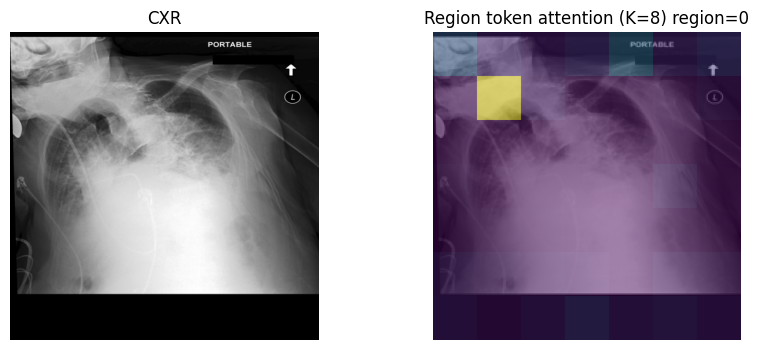

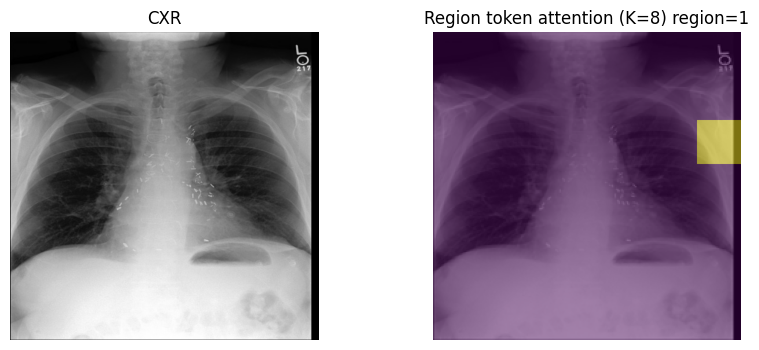

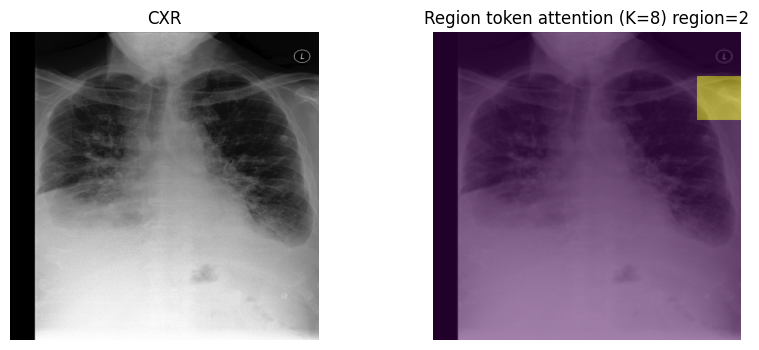

In [30]:
import matplotlib.pyplot as plt

@torch.no_grad()
def show_attention(model, df, idx=0, region_id=0):
    model.eval()
    p = df.loc[idx, "best_frontal_path"]
    img0 = Image.open(p).convert("RGB")
    x = tfm(img0).unsqueeze(0).to(device)
    out = model(x, concept_emb_bert)
    attn = out["reg_attn"][0, region_id]  # [HW]
    feat = out["feat_map"]                # [1,C,h,w]
    _,_,h,w = feat.shape
    attn_map = attn.view(h,w).float().cpu().numpy()
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("CXR")
    plt.imshow(img0)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title(f"Region token attention (K={K_REGIONS}) region={region_id}")
    plt.imshow(img0.resize((IMG_SIZE, IMG_SIZE)))
    plt.imshow(attn_map.repeat(IMG_SIZE//h, axis=0).repeat(IMG_SIZE//w, axis=1), alpha=0.5)
    plt.axis("off")
    plt.show()

# visualize a few random samples
for rid in [0,1,2]:
    show_attention(model, df_va, idx=np.random.randint(0, len(df_va)), region_id=rid)


In [32]:
import os, json, re, math
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

PHASE2_DIR = "/kaggle/working/phase2_outputs_v1"
PHASE3_DIR = "/kaggle/working/phase3_outputs_v1"
PHASE4_DIR = "/kaggle/working/phase4_outputs_v1"
os.makedirs(PHASE4_DIR, exist_ok=True)

PHASE2_JSON = os.path.join(PHASE2_DIR, "phase2_metrics_and_thresholds.json")
PHASE3_CKPT = os.path.join(PHASE3_DIR, "phase3_profa_best.pt")
CONCEPT_BANK_PATH = os.path.join(PHASE3_DIR, "phase3_concept_bank.json")

with open(PHASE2_JSON, "r") as f:
    phase2_meta = json.load(f)

thr = np.array([phase2_meta["thr_tuned"][k] for k in phase2_meta["thr_tuned"].keys()], dtype=np.float32)
print("Loaded tuned thresholds shape:", thr.shape)


device: cuda
Loaded tuned thresholds shape: (14,)


---------------------------------

## **PHASE 4** 

In [33]:
SECTION_HEADERS = [
    "history", "indication", "reason for exam", "reason for study", "clinical history",
    "findings", "impression", "comparison", "technique"
]

def _clean_text(t: str) -> str:
    if not isinstance(t, str):
        return ""
    t = t.replace("\r", "\n")
    t = re.sub(r"\n{2,}", "\n", t)
    return t.strip()

def parse_mimic_report(text: str):
    """
    Returns dict with indication/findings/impression.
    If missing, fills with empty string.
    """
    t = _clean_text(text).lower()
    # Normalize headers like "FINDINGS:" etc.
    t = re.sub(r"([a-z ]+)\s*:\s*", lambda m: m.group(1).strip()+": ", t)

    # simple section splitting by known headers
    # We'll find all header positions then slice.
    positions = []
    for h in SECTION_HEADERS:
        m = re.search(rf"\b{re.escape(h)}\s*:\s*", t)
        if m:
            positions.append((m.start(), h))
    positions.sort()

    out = {"indication": "", "findings": "", "impression": ""}
    if not positions:
        # fallback: treat whole as findings
        out["findings"] = _clean_text(text)
        return out

    # add end sentinel
    spans = []
    for i, (pos, h) in enumerate(positions):
        end = positions[i+1][0] if i+1 < len(positions) else len(t)
        spans.append((h, pos, end))

    # extract raw substrings
    for (h, s, e) in spans:
        # skip header token itself
        m = re.search(r":\s*", t[s:e])
        if not m:
            continue
        content = t[s:e][m.end():].strip()
        if h in ["history", "clinical history", "reason for exam", "reason for study", "indication"]:
            if not out["indication"]:
                out["indication"] = content
        elif h == "findings":
            out["findings"] = content
        elif h == "impression":
            out["impression"] = content

    # fallback fill
    if not out["findings"] and out["impression"]:
        out["findings"] = ""
    if not out["impression"] and out["findings"]:
        out["impression"] = ""
    return {k: _clean_text(v) for k, v in out.items()}


In [39]:
import json

CONCEPT_BANK_PATH = "/kaggle/working/phase3_outputs_v1/phase3_concept_bank.json"

with open(CONCEPT_BANK_PATH, "r") as f:
    cb = json.load(f)

CONCEPTS = cb["concept_texts"]             # 31 strings like "anatomy: lung"
CONCEPT_TYPES = cb["concept_types"]        # 31 strings like "anatomy"

# Optional: prompts = concepts (or you can customize prompts later)
CONCEPT_PROMPTS = CONCEPTS

print("N_CONCEPTS:", len(CONCEPTS))
print("Sample:", list(zip(CONCEPTS[:5], CONCEPT_TYPES[:5])))

N_CONCEPTS: 31
Sample: [('anatomy: lung', 'anatomy'), ('anatomy: left lung', 'anatomy'), ('anatomy: right lung', 'anatomy'), ('anatomy: upper lobe', 'anatomy'), ('anatomy: lower lobe', 'anatomy')]


In [44]:
import os, json
import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

PHASE1_DIR = "/kaggle/working/phase1_outputs_v2"
PHASE2_DIR = "/kaggle/working/phase2_outputs_v1"
PHASE3_DIR = "/kaggle/working/phase3_outputs_v1"
PHASE4_DIR = "/kaggle/working/phase4_outputs_v1"
os.makedirs(PHASE4_DIR, exist_ok=True)

PHASE2_CKPT = os.path.join(PHASE2_DIR, "best_multiview_classifier_clean.pt")
PHASE2_JSON  = os.path.join(PHASE2_DIR, "phase2_metrics_and_thresholds.json")

PHASE3_CKPT  = os.path.join(PHASE3_DIR, "phase3_profa_best.pt")
PHASE3_BANK  = os.path.join(PHASE3_DIR, "phase3_concept_bank.json")

for p in [PHASE2_CKPT, PHASE2_JSON, PHASE3_CKPT, PHASE3_BANK]:
    assert os.path.exists(p), f"Missing: {p}"

print("PHASE2_CKPT:", PHASE2_CKPT)
print("PHASE3_CKPT:", PHASE3_CKPT)
print("PHASE3_BANK:", PHASE3_BANK)

device: cuda
PHASE2_CKPT: /kaggle/working/phase2_outputs_v1/best_multiview_classifier_clean.pt
PHASE3_CKPT: /kaggle/working/phase3_outputs_v1/phase3_profa_best.pt
PHASE3_BANK: /kaggle/working/phase3_outputs_v1/phase3_concept_bank.json


In [51]:
import timm

# ---- load phase2 metrics json (for thresholds in CHEX_LABELS order) ----
with open(PHASE2_JSON, "r") as f:
    phase2_info = json.load(f)

# phase2_info["thr_tuned"] is a dict label->threshold (saved by your Phase-2 cell)
thr_tuned = np.array([phase2_info["thr_tuned"][lab] for lab in CHEX_LABELS], dtype=np.float32)
print("thr_tuned sample:", thr_tuned[:5])

# ---- load phase2 clean checkpoint ----
ck2 = torch.load(PHASE2_CKPT, map_location="cpu", weights_only=False)

# your clean ckpt stores weights here:
sd2 = ck2["model_state_dict"]
backbone2 = ck2.get("backbone", "convnext_tiny")
img_size2 = int(ck2.get("img_size", 224))

# IMPORTANT: set pretrained=False to avoid timm trying to download weights;
# we load your trained weights anyway.
clf2 = MultiViewClassifier(backbone_name=backbone2, n_labels=N_LABELS)
missing, unexpected = clf2.load_state_dict(sd2, strict=True)
# strict=True should load cleanly; if it errors in some sessions, change to strict=False and print.
clf2 = clf2.to(device).eval()

print("Loaded Phase-2 classifier ✅")
print("  backbone:", backbone2, "img_size:", img_size2)

thr_tuned sample: [0.5  0.35 0.05 0.05 0.45]
Loaded Phase-2 classifier ✅
  backbone: convnext_tiny img_size: 224


In [46]:
with open(PHASE3_BANK, "r") as f:
    concept_bank = json.load(f)

# Correct keys in YOUR file:
CONCEPT_TEXTS = concept_bank["concept_texts"]     # list[str], len=31
CONCEPT_TYPES = concept_bank["concept_types"]     # list[str], len=31

print("N_CONCEPTS:", len(CONCEPT_TEXTS))
print("Sample concepts:", CONCEPT_TEXTS[:5])
print("Sample types:", CONCEPT_TYPES[:5])

N_CONCEPTS: 31
Sample concepts: ['anatomy: lung', 'anatomy: left lung', 'anatomy: right lung', 'anatomy: upper lobe', 'anatomy: lower lobe']
Sample types: ['anatomy', 'anatomy', 'anatomy', 'anatomy', 'anatomy']


In [47]:
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

TXT_ENCODER_NAME = "emilyalsentzer/Bio_ClinicalBERT"
CONCEPT_EMB_CACHE = os.path.join(PHASE4_DIR, "concept_emb_bioclinicalbert.pt")

def embed_concepts_bioclinicalbert(concept_texts, device, max_len=64, bs=32):
    tok = AutoTokenizer.from_pretrained(TXT_ENCODER_NAME)
    enc = AutoModel.from_pretrained(TXT_ENCODER_NAME).to(device).eval()

    embs = []
    with torch.no_grad():
        for i in range(0, len(concept_texts), bs):
            batch = concept_texts[i:i+bs]
            x = tok(batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(device)
            out = enc(**x).last_hidden_state  # [B, T, H]
            mask = x["attention_mask"].unsqueeze(-1).float()  # [B, T, 1]
            pooled = (out * mask).sum(dim=1) / (mask.sum(dim=1).clamp_min(1.0))  # mean pool
            pooled = F.normalize(pooled, dim=-1)
            embs.append(pooled.detach().cpu())
    return torch.cat(embs, dim=0)  # [N, H]

if os.path.exists(CONCEPT_EMB_CACHE):
    concept_emb = torch.load(CONCEPT_EMB_CACHE, map_location="cpu")
    print("Loaded cached concept_emb:", CONCEPT_EMB_CACHE, concept_emb.shape)
else:
    concept_emb = embed_concepts_bioclinicalbert(CONCEPT_TEXTS, device=device, max_len=64, bs=32)
    torch.save(concept_emb, CONCEPT_EMB_CACHE)
    print("Saved concept_emb:", CONCEPT_EMB_CACHE, concept_emb.shape)

# Keep a GPU copy for fast inference
concept_emb_gpu = concept_emb.to(device).float()

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: emilyalsentzer/Bio_ClinicalBERT
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Saved concept_emb: /kaggle/working/phase4_outputs_v1/concept_emb_bioclinicalbert.pt torch.Size([31, 768])


In [48]:
import timm

ck3 = torch.load(PHASE3_CKPT, map_location="cpu", weights_only=False)
sd3 = ck3["model_state_dict"]

# These were saved in your Phase-3 ckpt:
backbone3_name = ck3.get("backbone_name", "convnext_tiny")
out_index      = int(ck3.get("out_index", 3))
k_regions      = int(ck3.get("k_regions", 8))
d_model        = int(ck3.get("d_model", 512))

# PROFA expects a features_only backbone that returns a feature map list
backbone3 = timm.create_model(
    backbone3_name,
    pretrained=False,              # don't download
    features_only=True,
    out_indices=(out_index,),
)

c_back = backbone3.feature_info.channels()[-1]

profa = PROFA(
    backbone=backbone3,
    c_back=c_back,
    d_model=d_model,
    k_regions=k_regions,
    n_labels=N_LABELS,
).to(device).eval()

# This should match your training definition (same notebook), so strict=True should work
profa.load_state_dict(sd3, strict=True)

print("Loaded Phase-3 PROFA ✅")
print("  backbone:", backbone3_name, "out_index:", out_index, "c_back:", c_back, "d_model:", d_model, "k_regions:", k_regions)


Loaded Phase-3 PROFA ✅
  backbone: convnext_tiny out_index: 3 c_back: 768 d_model: 512 k_regions: 8


In [55]:
def run_one_image_force_two_views(img_path, thr=None):
    if thr is None:
        thr = thr_tuned

    img = Image.open(img_path).convert("RGB")
    x = tfm_eval(img).unsqueeze(0).to(device) 

    # Phase 2 logic (unchanged)
    x_mv = torch.stack([x, x], dim=1) 
    view_mask = torch.ones((1, 2), device=device, dtype=torch.bool)

    with torch.no_grad():
        # Phase 2 prediction
        logits2 = clf2(x_mv, view_mask)
        p2 = torch.sigmoid(logits2).squeeze(0).float().cpu().numpy()

        output_dict = model(x, concept_emb_bert=concept_emb_gpu) 
        
        logits3 = output_dict["log_mil"]
        p3 = torch.sigmoid(logits3).squeeze(0).float().cpu().numpy()
    
        s_con = p3 

    pred2 = [CHEX_LABELS[i] for i in range(N_LABELS) if p2[i] >= thr[i]]
    pred3 = [CHEX_LABELS[i] for i in range(N_LABELS) if p3[i] >= 0.5]

    topk = np.argsort(-s_con)[:10]
    top_concepts = [(CHEX_LABELS[i], float(s_con[i])) for i in topk]

    return {
        "phase2_pred_labels_tuned": pred2, 
        "phase3_pred_labels@0.5": pred3, 
        "top_concepts": top_concepts
    }

print(run_one_image_force_two_views("/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1000_IM-0003-1001.dcm.png"))

{'phase2_pred_labels_tuned': ['Lung Opacity', 'Lung Lesion', 'Pneumonia', 'Atelectasis', 'Pleural Other', 'Fracture', 'Support Devices'], 'phase3_pred_labels@0.5': ['Lung Opacity', 'Atelectasis', 'Pleural Other', 'Fracture', 'Support Devices', 'No Finding'], 'top_concepts': [('No Finding', 0.996604323387146), ('Support Devices', 0.9920666217803955), ('Pleural Other', 0.9324855208396912), ('Atelectasis', 0.695793628692627), ('Fracture', 0.6266810297966003), ('Lung Opacity', 0.5760067701339722), ('Lung Lesion', 0.3916879892349243), ('Pneumonia', 0.36948928236961365), ('Pleural Effusion', 0.35865262150764465), ('Cardiomegaly', 0.354529470205307)]}


--------------------------------------

### *A*

In [60]:
import os, json
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image
import torch

def _to_py(x):
    """Convert numpy/torch scalars/arrays to pure python types."""
    if isinstance(x, (np.integer,)):
        return int(x)
    if isinstance(x, (np.floating,)):
        return float(x)
    if isinstance(x, (np.ndarray,)):
        return x.tolist()
    if torch.is_tensor(x):
        return x.detach().cpu().numpy().tolist()
    return x

def dumps_json(obj) -> str:
    return json.dumps(obj, default=_to_py, ensure_ascii=False)

def load_rgb(path):
    return Image.open(path).convert("RGB")

def img_transform(img, size=224):
    import torchvision.transforms as T
    tfm = T.Compose([T.Resize((size, size)), T.ToTensor()])
    return tfm(img)


In [61]:
import torch.nn.functional as F
import types

# ---- If you already patched these methods, you can skip this whole cell ----
# But keeping it here makes Phase-4 reproducible.
def encode_tokens(self, x):
    feat = self.backbone(x)[0]         # [B, C, h, w]
    B, C, h, w = feat.shape

    pix = feat.permute(0,2,3,1).contiguous().view(B, h*w, C)
    pixD = self.proj_pix(pix)          # [B, HW, D]

    Q = self.region_queries.unsqueeze(0).expand(B, -1, -1)
    reg, _ = self.region_attn(Q, pixD, pixD, need_weights=False) # [B, K, D]

    org = feat.mean(dim=(2,3))
    orgD = self.proj_org(org)          # [B, D]
    return pixD, reg, orgD

def concept_scores(self, region_tok):
    cB = concept_emb_bert.to(region_tok.device)          # [N, 768]
    cD = F.normalize(self.proj_concept(cB), dim=-1)      # [N, D]
    regN = F.normalize(region_tok, dim=-1)               # [B, K, D]
    scores = torch.einsum("bkd,nd->bkn", regN, cD)       # [B, K, N]
    return scores

# Attach if missing
if not hasattr(profa, "encode_tokens"):
    profa.encode_tokens = types.MethodType(encode_tokens, profa)
if not hasattr(profa, "concept_scores"):
    profa.concept_scores = types.MethodType(concept_scores, profa)

print("✅ PROFA has encode_tokens + concept_scores")

@torch.no_grad()
def extract_one(frontal_path: str, img_size=224, topk_per_region=3):
    # ---- Load frontal ----
    img_tensor = img_transform(load_rgb(frontal_path), size=img_size)  # [3,H,W]
    C, H, W = img_tensor.shape

    # ---- Phase-2 expects [B,2,C,H,W] + view_mask [B,2] ----
    dummy_lateral = torch.zeros(C, H, W)
    x_views = torch.stack([img_tensor, dummy_lateral], dim=0).unsqueeze(0).to(device)  # [1,2,3,H,W]
    view_mask = torch.tensor([[1.0, 0.0]], device=device)  # frontal present, lateral missing

    logits2 = clf2(x_views, view_mask)   # [1,14]
    p2 = torch.sigmoid(logits2).squeeze(0).float().cpu().numpy()  # [14]
    yhat2 = (p2 >= thr).astype(np.int32)                           # [14]

    # ---- Phase-3 expects [B,C,H,W] ----
    img_batch = img_tensor.unsqueeze(0).to(device)  # [1,3,H,W]
    _, region_tok, _ = profa.encode_tokens(img_batch)              # region_tok [1,K,D]
    S = profa.concept_scores(region_tok)[0].float().cpu().numpy()  # [K,N_CONCEPTS]

    # concept_max: [N_CONCEPTS] (use this for retrieval)
    concept_max = S.max(axis=0)

    # region_top_concepts: list[K] of topk tuples (interpretability only)
    region_top = []
    for k in range(S.shape[0]):
        idx = np.argsort(-S[k])[:topk_per_region]
        region_top.append([(CONCEPTS[i], float(S[k, i])) for i in idx])

    return {
        "label_probs": [float(v) for v in p2],
        "label_pred":  [int(v) for v in yhat2],
        "concept_max": [float(v) for v in concept_max],
        "region_top_concepts": region_top
    }


✅ PROFA has encode_tokens + concept_scores


In [62]:
PHASE4_DIR = PHASE3_DIR.replace("phase3_outputs_v1", "phase4_outputs_v1") if "PHASE4_DIR" not in globals() else PHASE4_DIR
os.makedirs(PHASE4_DIR, exist_ok=True)
print("PHASE4_DIR:", PHASE4_DIR)

SAVE_EVERY = 500  # smaller chunks = less loss on crash
part_prefix = "mimic_train_evidence_part"

def _existing_parts():
    files = [f for f in os.listdir(PHASE4_DIR) if f.startswith(part_prefix) and f.endswith(".parquet")]
    return sorted(files)

# Resume: find how many rows already cached
start_i = 0
files = _existing_parts()
if files:
    # Expect filenames like mimic_train_evidence_part0500.parquet, part1000, etc.
    last = files[-1]
    num = "".join([c for c in last if c.isdigit()])
    if num:
        start_i = int(num)
print("Resuming from i =", start_i, "out of", len(df_tr))

rows = []
for i in tqdm(range(start_i, len(df_tr)), desc="phase4A cache"):
    r = df_tr.iloc[i]
    path = r["best_frontal_path"]

    # Parse report sections (assumes your function exists)
    sec = parse_mimic_report(r["text"])

    try:
        ev = extract_one(path)
    except Exception as e:
        # Keep schema stable: store empties instead of NaN/float
        ev = {
            "label_probs": None,
            "label_pred": None,
            "concept_max": None,
            "region_top_concepts": []
        }
        # (Optional) log
        # print("WARN extract failed at i=", i, "path=", path, "err=", repr(e))

    rows.append({
        "row_idx": int(i),
        "subject_id": int(r["subject_id"]),
        "path": path,

        "indication": sec.get("indication", "") if sec is not None else "",
        "findings":   sec.get("findings", "") if sec is not None else "",
        "impression": sec.get("impression", "") if sec is not None else "",

        # JSON strings => Parquet-safe, stable schema
        "label_probs_json": dumps_json(ev["label_probs"]) if ev["label_probs"] is not None else "",
        "label_pred_json":  dumps_json(ev["label_pred"])  if ev["label_pred"]  is not None else "",
        "concept_max_json": dumps_json(ev["concept_max"]) if ev["concept_max"] is not None else "",
        "region_top_json":  dumps_json(ev["region_top_concepts"]),
    })

    if (i + 1) % SAVE_EVERY == 0:
        tmp = pd.DataFrame(rows)
        out_path = os.path.join(PHASE4_DIR, f"{part_prefix}{i+1:06d}.parquet")
        tmp.to_parquet(out_path, index=False)
        rows = []

# flush remainder
if rows:
    tmp = pd.DataFrame(rows)
    out_path = os.path.join(PHASE4_DIR, f"{part_prefix}{len(df_tr):06d}.parquet")
    tmp.to_parquet(out_path, index=False)

print("✅ Phase4A cache written into:", PHASE4_DIR)
print("Sample files:", _existing_parts()[:5], "... total:", len(_existing_parts()))


PHASE4_DIR: /kaggle/working/phase4_outputs_v1
Resuming from i = 0 out of 40656


phase4A cache:   0%|          | 0/40656 [00:00<?, ?it/s]

✅ Phase4A cache written into: /kaggle/working/phase4_outputs_v1
Sample files: ['mimic_train_evidence_part000500.parquet', 'mimic_train_evidence_part001000.parquet', 'mimic_train_evidence_part001500.parquet', 'mimic_train_evidence_part002000.parquet', 'mimic_train_evidence_part002500.parquet'] ... total: 82


In [63]:
import glob

def read_phase4_parts(phase4_dir):
    paths = sorted(glob.glob(os.path.join(phase4_dir, f"{part_prefix}*.parquet")))
    dfs = [pd.read_parquet(p) for p in paths]
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

df_ev = read_phase4_parts(PHASE4_DIR)
print("Loaded evidence df:", df_ev.shape)
print(df_ev.head(2))

# Example decode
ex = df_ev.iloc[0]
label_probs = json.loads(ex["label_probs_json"]) if ex["label_probs_json"] else None
concept_max = json.loads(ex["concept_max_json"]) if ex["concept_max_json"] else None
region_top  = json.loads(ex["region_top_json"])  if ex["region_top_json"]  else None
print("Decoded:", type(label_probs), type(concept_max), type(region_top))

Loaded evidence df: (40656, 10)
   row_idx  subject_id                                               path  \
0        0    10000032  /kaggle/input/mimic-cxr-dataset/official_data_...   
1        1    10000764  /kaggle/input/mimic-cxr-dataset/official_data_...   

  indication                                           findings  \
0             there is no focal consolidation, pleural effus...   
1             pa and lateral views of the chest provided.   ...   

                                          impression  \
0  no acute cardiopulmonary process.', 'findings:...   
1  focal consolidation at the left lung base, pos...   

                                    label_probs_json  \
0  [0.2913752496242523, 0.25357797741889954, 0.36...   
1  [0.8034101128578186, 0.7887207865715027, 0.676...   

                              label_pred_json  \
0  [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]   
1  [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]   

                                    concept_max_

### *B*

In [65]:
import os, glob, json
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

PHASE4_DIR = "/kaggle/working/phase4_outputs_v1"
PHASE4B_DIR = os.path.join(PHASE4_DIR, "retrieval_index_v1")
os.makedirs(PHASE4B_DIR, exist_ok=True)

print("PHASE4_DIR:", PHASE4_DIR)
print("PHASE4B_DIR:", PHASE4B_DIR)

# ----------------------------
# Helpers
# ----------------------------
def _ensure_list(x):
    """Evidence columns may be stored as list or JSON string; normalize."""
    if isinstance(x, list):
        return x
    if x is None:
        return []
    if isinstance(x, str):
        x = x.strip()
        if x == "":
            return []
        return json.loads(x)
    # pyarrow / numpy object fallback
    try:
        return list(x)
    except Exception:
        return []

def _stack_col(df, col, expected_len, dtype=np.float32):
    arrs = []
    bad = 0
    for v in df[col].tolist():
        lst = _ensure_list(v)
        if len(lst) != expected_len:
            bad += 1
            # pad / truncate to be safe
            if len(lst) < expected_len:
                lst = lst + [0.0] * (expected_len - len(lst))
            else:
                lst = lst[:expected_len]
        arrs.append(np.asarray(lst, dtype=dtype))
    if bad:
        print(f"[WARN] {col}: fixed length mismatch for {bad} rows")
    return np.stack(arrs, axis=0)

# ----------------------------
# Load all evidence parts
# ----------------------------
parts = sorted(glob.glob(os.path.join(PHASE4_DIR, "mimic_train_evidence_part*.parquet")))
assert len(parts) > 0, "No Phase4A evidence parts found."

use_cols = [
    "row_idx", "subject_id", "path",
    "indication", "findings", "impression",
    "label_probs_json", "label_pred_json",
    "concept_max_json",
    # region_top_json is optional and large; keep out for retrieval index
]
dfs = []
for p in tqdm(parts, desc="Loading evidence parts"):
    dfs.append(pd.read_parquet(p, columns=[c for c in use_cols if c in pd.read_parquet(p).columns]))
df_ev = pd.concat(dfs, ignore_index=True)

df_ev = df_ev.sort_values("row_idx").reset_index(drop=True)
print("Loaded evidence df:", df_ev.shape)
print(df_ev.head(2)[["row_idx","subject_id","path"]])

# ----------------------------
# Build retrieval vectors: concat([phase2_probs(14), concept_max(31)]) => 45 dims
# ----------------------------
P = _stack_col(df_ev, "label_probs_json", expected_len=14, dtype=np.float32)
C = _stack_col(df_ev, "concept_max_json", expected_len=31, dtype=np.float32)
X = np.concatenate([P, C], axis=1).astype(np.float32)  # (N,45)

# L2 normalize for cosine retrieval
X_norm = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)

print("X:", X.shape, "X_norm:", X_norm.shape, "dtype:", X_norm.dtype)

# Save index arrays
vec_path = os.path.join(PHASE4B_DIR, "train_vecs_norm_fp32.npy")
meta_path = os.path.join(PHASE4B_DIR, "train_meta.parquet")

np.save(vec_path, X_norm)

# Save lightweight meta
meta = df_ev[["row_idx","subject_id","path","indication","findings","impression"]].copy()
meta.to_parquet(meta_path, index=False)

print("✅ Saved retrieval index:")
print("  vecs:", vec_path)
print("  meta:", meta_path)
print("  N:", len(meta), "D:", X_norm.shape[1])


PHASE4_DIR: /kaggle/working/phase4_outputs_v1
PHASE4B_DIR: /kaggle/working/phase4_outputs_v1/retrieval_index_v1


Loading evidence parts:   0%|          | 0/82 [00:00<?, ?it/s]

Loaded evidence df: (40656, 9)
   row_idx  subject_id                                               path
0        0    10000032  /kaggle/input/mimic-cxr-dataset/official_data_...
1        1    10000764  /kaggle/input/mimic-cxr-dataset/official_data_...
X: (40656, 45) X_norm: (40656, 45) dtype: float32
✅ Saved retrieval index:
  vecs: /kaggle/working/phase4_outputs_v1/retrieval_index_v1/train_vecs_norm_fp32.npy
  meta: /kaggle/working/phase4_outputs_v1/retrieval_index_v1/train_meta.parquet
  N: 40656 D: 45


In [66]:
import numpy as np
import pandas as pd

vec_path = os.path.join(PHASE4B_DIR, "train_vecs_norm_fp32.npy")
meta_path = os.path.join(PHASE4B_DIR, "train_meta.parquet")

train_vecs = np.load(vec_path, mmap_mode="r")     # (N,45) normalized
train_meta = pd.read_parquet(meta_path)           # N rows

print("train_vecs:", train_vecs.shape, train_vecs.dtype)
print("train_meta:", train_meta.shape)

def l2norm(v: np.ndarray) -> np.ndarray:
    v = v.astype(np.float32, copy=False)
    return v / (np.linalg.norm(v) + 1e-12)

def retrieve_topk(query_vec_45: np.ndarray, k: int = 5, block: int = 8192):
    """
    Cosine retrieval on normalized vectors.
    query_vec_45: shape (45,) or (1,45)
    """
    q = query_vec_45.reshape(-1).astype(np.float32)
    q = l2norm(q)

    N = train_vecs.shape[0]
    best_scores = np.full((k,), -1e9, dtype=np.float32)
    best_idx = np.full((k,), -1, dtype=np.int64)

    for s in range(0, N, block):
        e = min(N, s + block)
        sims = train_vecs[s:e] @ q  # (block,)
        if len(sims) <= k:
            local_top = np.arange(len(sims))
        else:
            local_top = np.argpartition(sims, -k)[-k:]

        cand_scores = sims[local_top]
        cand_idx = local_top + s

        # merge with running topk
        all_scores = np.concatenate([best_scores, cand_scores])
        all_idx = np.concatenate([best_idx, cand_idx])

        sel = np.argpartition(all_scores, -k)[-k:]
        best_scores = all_scores[sel]
        best_idx = all_idx[sel]

    order = np.argsort(-best_scores)
    best_scores = best_scores[order]
    best_idx = best_idx[order]
    return best_idx, best_scores

# quick self-test: retrieve for first training vector
idx, sc = retrieve_topk(train_vecs[0], k=5)
print("Top-5 indices:", idx)
print("Top-5 scores:", sc)
print(train_meta.iloc[idx][["row_idx","subject_id"]].head())


train_vecs: (40656, 45) float32
train_meta: (40656, 6)
Top-5 indices: [    0 39723 26807 19096 32947]
Top-5 scores: [1.         0.9995107  0.99944365 0.99943715 0.99941915]
       row_idx  subject_id
0            0    10000032
39723    39723    19773650
26807    26807    16589824
19096    19096    14685473
32947    32947    18091968


### *C*

In [67]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np

# IMPORTANT: use the same img_size used in Phase-2/3 training
IMG_SIZE = 224

def load_rgb(path):
    return Image.open(path).convert("RGB")

def img_transform(img, size=224):
    import torchvision.transforms as T
    tfm = T.Compose([T.Resize((size,size)), T.ToTensor()])
    return tfm(img)

@torch.no_grad()
def query_vec_from_image(path: str):
    """
    Returns:
      q45: np.ndarray (45,) = concat([phase2_probs(14), concept_max(31)]) then L2 normalized outside if needed
      p14: (14,) probs
      concept_max31: (31,) max-over-regions scores
    """
    img = img_transform(load_rgb(path), size=IMG_SIZE)  # [3,H,W]

    # ---- Phase-2 expects [B,2,C,H,W] + view_mask ----
    C, H, W = img.shape
    dummy_lateral = torch.zeros(C, H, W)
    x_views = torch.stack([img, dummy_lateral], dim=0).unsqueeze(0).to(device)  # [1,2,3,H,W]
    view_mask = torch.tensor([[1.0, 0.0]], device=device)                       # [1,2]

    with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        logits2 = clf2(x_views, view_mask)               # [1,14]
        p14 = torch.sigmoid(logits2).squeeze(0).float().cpu().numpy()

    # ---- Phase-3 expects [B,C,H,W] ----
    x = img.unsqueeze(0).to(device)                      # [1,3,H,W]
    with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        # Use your profa.encode_tokens and profa.concept_scores (as you patched)
        _, region_tok, _ = profa.encode_tokens(x)        # region_tok: [1,K,D]
        scores = profa.concept_scores(region_tok)[0]     # [K, N_CONCEPTS]
        concept_max31 = scores.max(dim=0).values.float().cpu().numpy()  # [31]

    q45 = np.concatenate([p14.astype(np.float32), concept_max31.astype(np.float32)], axis=0)
    return q45, p14, concept_max31

# Demo on one image (replace with any known path)
demo_path = train_meta.iloc[0]["path"]
q45, p14, c31 = query_vec_from_image(demo_path)
print("q45:", q45.shape, "p14:", p14.shape, "c31:", c31.shape)


q45: (45,) p14: (14,) c31: (31,)


In [68]:
def generate_by_retrieval(query_path: str, k: int = 5):
    q45, p14, c31 = query_vec_from_image(query_path)
    q45n = q45 / (np.linalg.norm(q45) + 1e-12)

    idx, sc = retrieve_topk(q45n, k=k)
    neighbors = train_meta.iloc[idx].copy()
    neighbors["sim"] = sc

    # Option-B v0: take top-1 report as generated
    top1 = neighbors.iloc[0]
    gen = {
        "query_path": query_path,
        "retrieved_row_idx": int(top1["row_idx"]),
        "retrieved_subject_id": int(top1["subject_id"]),
        "sim": float(top1["sim"]),
        "generated_findings": str(top1["findings"]),
        "generated_impression": str(top1["impression"]),
        "phase2_probs": p14.tolist(),
        "concept_max": c31.tolist(),
    }
    return gen, neighbors

# Demo
gen, neighbors = generate_by_retrieval(demo_path, k=5)
print("Generated impression (top1):\n", gen["generated_impression"][:600], "...\n")
print(neighbors[["row_idx","subject_id","sim"]].head(5))


Generated impression (top1):
 no acute cardiopulmonary process.', 'findings: the cardiac, mediastinal and hilar contours are normal. pulmonary vasculature is normal.  lungs are clear. no pleural effusion or pneumothorax is present. multiple clips are again seen projecting over the left breast.  remote left-sided rib fractures are also re- demonstrated.impression: no acute cardiopulmonary abnormality.', 'findings: single frontal view of the chest provided.  there is no focal consolidation, effusion, or pneumothorax. the cardiomediastinal silhouette is normal.  again seen are multiple clips projecting over the left breast an ...

       row_idx  subject_id       sim
0            0    10000032  0.999998
39723    39723    19773650  0.999500
26807    26807    16589824  0.999421
19096    19096    14685473  0.999387
32947    32947    18091968  0.999376


### *D*

In [69]:
import pandas as pd
import os, json
from tqdm.auto import tqdm

PHASE1_DIR = "/kaggle/working/phase1_outputs_v2"
holdout_path = os.path.join(PHASE1_DIR, "mimic_val_chexbert.parquet")
df_holdout = pd.read_parquet(holdout_path)
print("Loaded holdout:", df_holdout.shape)

# Try to locate the image path column robustly
path_col = None
for c in ["best_frontal_path", "path", "frontal_path"]:
    if c in df_holdout.columns:
        path_col = c
        break
assert path_col is not None, f"Couldn't find image path column in holdout. Columns: {df_holdout.columns.tolist()}"

# Filter existing files (safety)
df_holdout = df_holdout[df_holdout[path_col].notna()].copy()
df_holdout = df_holdout[df_holdout[path_col].apply(lambda p: os.path.exists(p))].reset_index(drop=True)
print("Holdout with existing images:", df_holdout.shape, "path_col:", path_col)

out_rows = []
OUT_PARQUET = os.path.join(PHASE4_DIR, "holdout_generated_v0.parquet")

for i in tqdm(range(len(df_holdout)), desc="Holdout retrieval-gen"):
    pth = df_holdout.loc[i, path_col]
    try:
        gen, neigh = generate_by_retrieval(pth, k=5)
        out_rows.append({
            "i": i,
            "path": gen["query_path"],
            "sim": gen["sim"],
            "retrieved_row_idx": gen["retrieved_row_idx"],
            "retrieved_subject_id": gen["retrieved_subject_id"],
            "generated_findings": gen["generated_findings"],
            "generated_impression": gen["generated_impression"],
            "phase2_probs_json": json.dumps(gen["phase2_probs"]),
            "concept_max_json": json.dumps(gen["concept_max"]),
            "retrieved_topk_json": json.dumps(
                neigh[["row_idx","subject_id","sim"]].to_dict(orient="records")
            )
        })
    except Exception as e:
        out_rows.append({"i": i, "path": pth, "error": str(e)})

df_out = pd.DataFrame(out_rows)
df_out.to_parquet(OUT_PARQUET, index=False)
print("✅ Saved:", OUT_PARQUET)
print(df_out.head(3))


Loaded holdout: (500, 26)
Holdout with existing images: (330, 26) path_col: best_frontal_path


Holdout retrieval-gen:   0%|          | 0/330 [00:00<?, ?it/s]

✅ Saved: /kaggle/working/phase4_outputs_v1/holdout_generated_v0.parquet
   i                                               path       sim  \
0  0  /kaggle/input/mimic-cxr-dataset/official_data_...  0.999741   
1  1  /kaggle/input/mimic-cxr-dataset/official_data_...  0.999856   
2  2  /kaggle/input/mimic-cxr-dataset/official_data_...  0.999857   

   retrieved_row_idx  retrieved_subject_id  \
0               9022              12226255   
1              37229              19151884   
2              10272              12522208   

                                  generated_findings  \
0                                                      
1  frontal and lateral chest radiograph demonstra...   
2  frontal and lateral views of the chest were ob...   

                                generated_impression  \
0  no previous images. cardiac silhouette is enla...   
1  unchanged right multiloculated pleural effusio...   
2  no acute cardiopulmonary process.', 'findings:...   

                

## **EVALUATION**

In [70]:
import os, json
import numpy as np
import pandas as pd

PHASE4_DIR = "/kaggle/working/phase4_outputs_v1"
PHASE1_DIR = "/kaggle/working/phase1_outputs_v2"   # where mimic_val_chexbert.parquet lives

GEN_PATH = os.path.join(PHASE4_DIR, "holdout_generated_v0.parquet")
VAL_PATH = os.path.join(PHASE1_DIR, "mimic_val_chexbert.parquet")

df_gen = pd.read_parquet(GEN_PATH)
df_val = pd.read_parquet(VAL_PATH)

print("df_gen:", df_gen.shape, "cols:", list(df_gen.columns)[:10])
print("df_val:", df_val.shape, "cols:", list(df_val.columns)[:10])

# resolve holdout image path column in df_val
path_col_candidates = ["best_frontal_path", "path", "frontal_path"]
path_col = next((c for c in path_col_candidates if c in df_val.columns), None)
assert path_col is not None, f"Couldn't find a path column in df_val. Tried {path_col_candidates}"

# merge (keep only rows where we can find the original report text)
need_cols = [path_col]
if "text" in df_val.columns: need_cols.append("text")
elif "report" in df_val.columns: need_cols.append("report")
else:
    raise AssertionError("df_val has no text/report column. Need original report text to evaluate.")

df_eval = df_gen.merge(df_val[need_cols], left_on="path", right_on=path_col, how="left")
df_eval = df_eval.dropna(subset=[need_cols[-1]]).reset_index(drop=True)
print("df_eval merged:", df_eval.shape)


df_gen: (330, 10) cols: ['i', 'path', 'sim', 'retrieved_row_idx', 'retrieved_subject_id', 'generated_findings', 'generated_impression', 'phase2_probs_json', 'concept_max_json', 'retrieved_topk_json']
df_val: (500, 26) cols: ['Unnamed: 0.1', 'Unnamed: 0', 'subject_id', 'image', 'view', 'AP', 'PA', 'Lateral', 'text', 'text_augment']
df_eval merged: (330, 12)


In [71]:
import re

assert "parse_mimic_report" in globals(), "parse_mimic_report() not found. Run the cell where you defined it."

gt_text_col = "text" if "text" in df_eval.columns else "report"

def clean_generated_impression(s: str) -> str:
    s = "" if s is None else str(s)
    s = s.strip()

    # If it looks like a stringified list/tuple fragments: "....', '....', '...."
    # Turn into one string.
    if ("', '" in s) or ('", "' in s):
        s = s.replace("', '", " ").replace('", "', " ")
        s = s.replace("['", " ").replace("']", " ")
        s = s.replace('["', " ").replace('"]', " ")
        s = s.replace("('", " ").replace("')", " ")
        s = s.replace('("', " ").replace('")', " ")

    # If it contains an impression header, take the last impression chunk
    low = s.lower()
    if "impression:" in low:
        idx = low.rfind("impression:")
        s = s[idx + len("impression:"):].strip()

    # Cleanup extra whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

def extract_gt_impression(report_text: str) -> str:
    sec = parse_mimic_report("" if report_text is None else str(report_text))
    imp = (sec.get("impression") or "").strip()
    if len(imp) > 0:
        return imp
    # fallback: if impression missing, use findings (better than empty)
    fnd = (sec.get("findings") or "").strip()
    return fnd if len(fnd) > 0 else ("" if report_text is None else str(report_text))

df_eval["gt_impression"]  = df_eval[gt_text_col].map(extract_gt_impression)
df_eval["gen_impression"] = df_eval["generated_impression"].map(clean_generated_impression)

print(df_eval[["path","sim","gt_impression","gen_impression"]].head(2))
print("Empty gen_impression %:", float(np.mean(df_eval["gen_impression"].str.len() == 0)))
print("Empty gt_impression % :", float(np.mean(df_eval["gt_impression"].str.len() == 0)))


                                                path       sim  \
0  /kaggle/input/mimic-cxr-dataset/official_data_...  0.999741   
1  /kaggle/input/mimic-cxr-dataset/official_data_...  0.999856   

                                       gt_impression  \
0  compared to chest radiographs since ___, most ...   
1  ', 'findings: low lung volumes, no pleural eff...   

                                      gen_impression  
0  no previous images. cardiac silhouette is enla...  
1  ap chest compared to ___ and ___: small right ...  
Empty gen_impression %: 0.08181818181818182
Empty gt_impression % : 0.0


In [72]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from transformers import AutoTokenizer, BertModel

# If your notebook already has these (Phase-1), this does nothing.
if "CHEX_LABELS" not in globals():
    CHEX_LABELS = [
        "Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity","Lung Lesion","Edema",
        "Consolidation","Pneumonia","Atelectasis","Pneumothorax","Pleural Effusion",
        "Pleural Other","Fracture","Support Devices","No Finding"
    ]

if "label_df_chexbert" not in globals():
    print("CheXbert labeler not found in globals() -> recreating it...")

    # Mapping used in your notebook:
    # 0=blank, 1=pos, 2=neg, 3=uncertain
    classid_to_chex_value = {0: np.nan, 1: 1.0, 2: 0.0, 3: -1.0}
    def classid_to_chex_value_fn(x: int) -> float:
        return classid_to_chex_value.get(int(x), np.nan)

    class CheXbertFromCheckpoint(nn.Module):
        def __init__(self, bert_name="bert-base-uncased", n_labels=14, head_dims=None):
            super().__init__()
            self.bert = BertModel.from_pretrained(bert_name)
            self.hidden = self.bert.config.hidden_size
            if head_dims is None:
                head_dims = [4]*13 + [2]
            assert len(head_dims) == n_labels
            self.linear_heads = nn.ModuleList([nn.Linear(self.hidden, d) for d in head_dims])

        def forward(self, input_ids, attention_mask):
            out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            cls = out.last_hidden_state[:, 0]  # [B,H]
            return [head(cls) for head in self.linear_heads]

    def infer_head_dims_from_ckpt(state_dict, n_labels=14):
        # Reads linear_heads.{i}.weight shapes
        dims = []
        for i in range(n_labels):
            wkey = f"module.linear_heads.{i}.weight"
            if wkey not in state_dict:
                wkey = f"linear_heads.{i}.weight"
            W = state_dict[wkey]
            dims.append(int(W.shape[0]))
        return dims

    @torch.no_grad()
    def chexbert_predict_classids(texts, max_len=256, batch_size=32):
        # lazy-init globals
        global chexbert_model, chexbert_tok, chexbert_class_ids

        if "chexbert_model" not in globals():
            # checkpoint from HF cache (same one you used)
            from huggingface_hub import hf_hub_download
            ckpt_path = hf_hub_download(
                repo_id="StanfordAIMI/RRG_scorers",
                filename="chexbert.pth",
            )
            ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
            sd = ckpt.get("state_dict", ckpt.get("model_state_dict", ckpt))

            head_dims = infer_head_dims_from_ckpt(sd, n_labels=14)
            chexbert_model = CheXbertFromCheckpoint("bert-base-uncased", n_labels=14, head_dims=head_dims)
            # strip "module." if needed
            sd2 = {k.replace("module.",""): v for k,v in sd.items()}
            chexbert_model.load_state_dict(sd2, strict=True)

            chexbert_tok = AutoTokenizer.from_pretrained("bert-base-uncased")

            # same mapping table used earlier: class_ids = [[0..],[1..],[2..],[3..]] (4x14)
            chexbert_class_ids = np.tile(np.array([[0],[1],[2],[3]]), (1,14))

            print("CheXbert loaded ✅ head_dims:", head_dims)

        device_local = "cuda" if torch.cuda.is_available() else "cpu"
        chexbert_model = chexbert_model.to(device_local).eval()

        all_ids = []
        for i in range(0, len(texts), batch_size):
            chunk = ["" if t is None else str(t) for t in texts[i:i+batch_size]]
            enc = chexbert_tok(
                chunk, padding=True, truncation=True, max_length=max_len, return_tensors="pt"
            )
            enc = {k: v.to(device_local) for k,v in enc.items()}
            logits_list = chexbert_model(enc["input_ids"], enc["attention_mask"])

            cids = []
            for j, logits in enumerate(logits_list):
                # logits: [B, Dj]
                pred = torch.argmax(logits, dim=-1).detach().cpu().numpy()  # [B]
                # map to 0/1/2/3 style ids when Dj=2: keep 0/1 (blank/pos-ish)
                if logits.shape[-1] == 2:
                    # treat class 1 as POS (id=1), class 0 as BLANK (id=0)
                    pred = pred.astype(np.int64)
                cids.append(pred)

            cids = np.stack(cids, axis=1)  # [B,14]
            all_ids.append(cids)

        return np.concatenate(all_ids, axis=0)

    @torch.no_grad()
    def label_df_chexbert(df: pd.DataFrame, text_col: str, batch_size=32, max_len=256):
        texts = df[text_col].fillna("").astype(str).tolist()
        all_vals = []
        for i in tqdm(range(0, len(texts), batch_size), desc="CheXbert labeling"):
            chunk = texts[i:i+batch_size]
            cids = chexbert_predict_classids(chunk, max_len=max_len, batch_size=batch_size)  # [b,14]
            vals = np.vectorize(classid_to_chex_value_fn)(cids)                               # [b,14]
            all_vals.append(vals)
        all_vals = np.concatenate(all_vals, axis=0)
        out = df.copy()
        for j, name in enumerate(CHEX_LABELS):
            out[name] = all_vals[:, j]
        return out

print("CheXbert labeler readydy ✅  (label_df_chexbert in globals:", "label_df_chexbert" in globals(), ")")


CheXbert labeler readydy ✅  (label_df_chexbert in globals: True )


In [73]:
def to_pos_uncertain(vals: np.ndarray) -> np.ndarray:
    # vals in {1,0,-1,nan} -> binary positive if (1 or -1), else 0; nan treated as 0 for predictions
    return ((vals == 1.0) | (vals == -1.0)).astype(np.int32)

def masked_f1_micro_macro(y_true01, y_pred01, mask):
    eps = 1e-9
    # micro
    yt = y_true01[mask]
    yp = y_pred01[mask]
    tp = (yt & yp).sum()
    fp = ((1-yt) & yp).sum()
    fn = (yt & (1-yp)).sum()
    p = tp / (tp + fp + eps)
    r = tp / (tp + fn + eps)
    f1_micro = 2*p*r/(p+r+eps)

    # macro per label (only where mask has at least 1 element)
    f1s = []
    for k in range(y_true01.shape[1]):
        mk = mask[:, k]
        if mk.sum() == 0:
            continue
        yt = y_true01[:, k][mk]
        yp = y_pred01[:, k][mk]
        tp = (yt & yp).sum()
        fp = ((1-yt) & yp).sum()
        fn = (yt & (1-yp)).sum()
        p = tp / (tp + fp + eps)
        r = tp / (tp + fn + eps)
        f1s.append(2*p*r/(p+r+eps))
    f1_macro = float(np.mean(f1s)) if len(f1s) else float("nan")
    return float(f1_micro), f1_macro

# Label both sides
df_gt_lab  = label_df_chexbert(pd.DataFrame({"t": df_eval["gt_impression"]}),  text_col="t", batch_size=32, max_len=256)
df_gen_lab = label_df_chexbert(pd.DataFrame({"t": df_eval["gen_impression"]}), text_col="t", batch_size=32, max_len=256)

GT  = df_gt_lab[CHEX_LABELS].to_numpy()
GEN = df_gen_lab[CHEX_LABELS].to_numpy()

# Evaluate only where GT is known (not NaN). GEN NaN becomes 0 (penalize missing mention).
mask = ~np.isnan(GT)
yt01 = to_pos_uncertain(GT)
yp01 = to_pos_uncertain(np.where(np.isnan(GEN), 0.0, GEN))

f1mi, f1ma = masked_f1_micro_macro(yt01, yp01, mask)

print("\n=== Phase-4B HOLDOUT CheXbert Agreement (Impression-only) ===")
print("N:", len(df_eval), "GT-known label fraction:", float(mask.mean()))
print("F1 micro:", f1mi)
print("F1 macro:", f1ma)

# per-label F1
per_label = []
for j, lab in enumerate(CHEX_LABELS):
    mk = mask[:, j]
    if mk.sum() == 0:
        per_label.append((lab, np.nan))
        continue
    yt = yt01[:, j][mk]
    yp = yp01[:, j][mk]
    tp = (yt & yp).sum()
    fp = ((1-yt) & yp).sum()
    fn = (yt & (1-yp)).sum()
    p = tp / (tp + fp + 1e-9)
    r = tp / (tp + fn + 1e-9)
    f1 = 2*p*r/(p+r+1e-9)
    per_label.append((lab, float(f1)))

per_label = sorted(per_label, key=lambda x: (np.nan_to_num(x[1], nan=-1.0)))
print("\nWorst 5 labels by F1:")
for lab, f1 in per_label[:5]:
    print(f"  {lab:28s} F1={f1}")

print("\nBest 5 labels by F1:")
for lab, f1 in per_label[-5:]:
    print(f"  {lab:28s} F1={f1}")


CheXbert labeling:   0%|          | 0/11 [00:00<?, ?it/s]

CheXbert labeling:   0%|          | 0/11 [00:00<?, ?it/s]


=== Phase-4B HOLDOUT CheXbert Agreement (Impression-only) ===
N: 330 GT-known label fraction: 0.2841991341991342
F1 micro: 0.400822199018283
F1 macro: 0.2295089803778733

Worst 5 labels by F1:
  Lung Lesion                  F1=0.0
  Pneumothorax                 F1=0.0
  Pleural Other                F1=0.0
  Enlarged Cardiomediastinum   F1=0.04347826070888469
  Consolidation                F1=0.07692307677514792

Best 5 labels by F1:
  Lung Opacity                 F1=0.32653061195147853
  Atelectasis                  F1=0.3333333330497076
  Pleural Effusion             F1=0.34042553152738797
  Cardiomegaly                 F1=0.3478260865966446
  No Finding                   F1=0.8711111106116741


* There is a significant skewness in the dataset of normal conditions.
* It would be best if we could make the database distribution better but that will itself take an LLM and will increase the time beyond the scope of this deadline 

In [74]:
OUT_JSON = os.path.join(PHASE4_DIR, "phase4_holdout_eval_chexbert.json")
OUT_CSV  = os.path.join(PHASE4_DIR, "phase4_holdout_eval_samples.csv")

# store a few examples
show = df_eval.copy()
show["gt_chex_pos_unc"]  = yt01.tolist()
show["gen_chex_pos_unc"] = yp01.tolist()
show["abs_diff"] = (np.abs(yt01 - yp01).sum(axis=1)).astype(int)

show = show.sort_values("abs_diff", ascending=False).head(30)
show[["path","sim","abs_diff","gt_impression","gen_impression"]].to_csv(OUT_CSV, index=False)

with open(OUT_JSON, "w") as f:
    json.dump({
        "N": int(len(df_eval)),
        "gt_known_label_fraction": float(mask.mean()),
        "f1_micro": float(f1mi),
        "f1_macro": float(f1ma),
        "per_label_f1": {lab: (None if np.isnan(v) else float(v)) for lab,v in per_label},
        "samples_csv": OUT_CSV,
    }, f, indent=2)

print("Saved:", OUT_JSON)
print("Saved:", OUT_CSV)


Saved: /kaggle/working/phase4_outputs_v1/phase4_holdout_eval_chexbert.json
Saved: /kaggle/working/phase4_outputs_v1/phase4_holdout_eval_samples.csv
